In [35]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## UTILITIES

In [36]:
def future_value(p, r, n):
    # include la logica di ri-investimento dei ritorni
    return p*(1 + r)**n

def present_value(f_value, r, n):
    # quanto avrei dovuto investire in un risk-free ai tassi attuali per ottenere lo stesso ritorno
    return f_value / (1 + r)**n

def neat_present_value(rate, cash_flow: dict):
    # fino a quale tasso l'investimento associato ai flussi di cassa è conveniente?
    tot_cf = 0.0
    for i in range(0, len(cash_flow)):
        tot_cf += present_value(cash_flow[i], rate, i)
    return tot_cf

def black_scholes(r, S, K, T, sigma, kind):
    # S = prezzo azione
    # K = prezzo esercizio
    # r = tasso interesse risk-free
    # sigma = varianza percentuale istantanea del logaritmo del prezzo del titolo sottostante
    # T = scadenza dell'opzione
    d1 = (np.log(S / K ) + (r + sigma**2 / 2)* T) / (sigma + np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if kind == "Call":
        option_price = S * norm.cdf(d1, 0, 1) - K * np.exp(-r*T) * norm.cdf(d2, 0, 1)
        return option_price
    elif kind == "Put":
        option_price = K * np.exp(-r*T) * norm.cdf(-d2, 0, 1) - S * norm.cdf(-d1, 0, 1)
        return option_price
    else:
        print("No Option type declared")
            

## Descriptive DataSet

In [37]:
tickers = ['AAPL', 'IBM', 'GOOG', 'AMZN', 'NVDA','AMD', 'NFLX', 'E', 
           'STLA', 'STM', 'PFE', 'DIS', 'LHCG', 'CVX', 'UEC', '^NDX']

stocks = ['Apple', 'IBM', 'Alphabet', 'Amazon', 'NVIDIA', 'AMD', 'Netflix', 'ENI',
         'Stellantis', 'STMicroelectronics',  'Pfizer', 'Walt_Disney', 'LHC Group', 
          'Chevron', 'Uranium Energy Corp', 'NASDAQ']

markets = ['Nasdaq', 'Nasdaq', 'Nasdaq', 'Nasdaq', 'Nasdaq', 'Nasdaq',  'Nasdaq', 'NYSE',
           'NYSE', 'NYSE', 'Nasdaq', 'Nasdaq', 'Nasdaq', 'Nasdaq', 'NYSE', 'NASDAQ']

fields = ['Informatica', 'Informatica', 'Informatica', 'Informatica', 'Elettronica', 'Elettronica', 
           'Intrattenimento', 'Energia', 'Automobilistico', 'Elettronica', 'Salute',
           'Intrattenimento', 'Salute', 'Energia', 'Energia', 'NASDAQ']

stocks_dict = {'ticker': tickers, 'stock': stocks, 'market': markets, 'field': fields}


stocks_df = pd.DataFrame(stocks_dict)

stocks_df

ticker                stock  market            field
0    AAPL                Apple  Nasdaq      Informatica
1     IBM                  IBM  Nasdaq      Informatica
2    GOOG             Alphabet  Nasdaq      Informatica
3    AMZN               Amazon  Nasdaq      Informatica
4    NVDA               NVIDIA  Nasdaq      Elettronica
5     AMD                  AMD  Nasdaq      Elettronica
6    NFLX              Netflix  Nasdaq  Intrattenimento
7       E                  ENI    NYSE          Energia
8    STLA           Stellantis    NYSE  Automobilistico
9     STM   STMicroelectronics    NYSE      Elettronica
10    PFE               Pfizer  Nasdaq           Salute
11    DIS          Walt_Disney  Nasdaq  Intrattenimento
12   LHCG            LHC Group  Nasdaq           Salute
13    CVX              Chevron  Nasdaq          Energia
14    UEC  Uranium Energy Corp    NYSE          Energia
15   ^NDX               NASDAQ  NASDAQ           NASDAQ

<AxesSubplot:xlabel='field'>

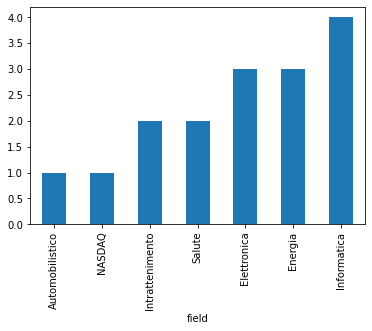

In [38]:
stocks_df.groupby('field').market.count().sort_values().plot(kind='bar')

## Assets' Fields

<AxesSubplot:ylabel='stock'>

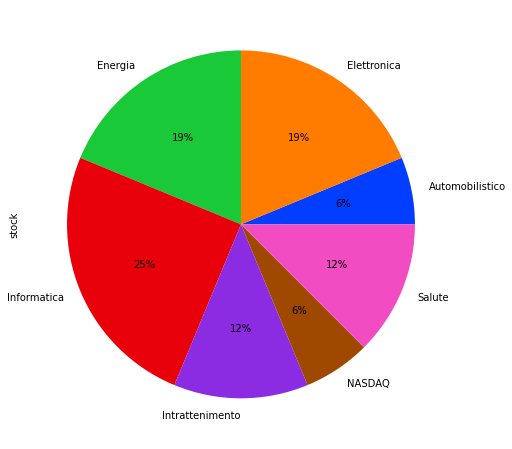

In [39]:
stocks_df.groupby('field').stock.count().plot.pie(figsize = (8, 8), 
                                                  colors = sns.color_palette('bright')[0:7], 
                                                  autopct='%.0f%%')

## Downloading Asset Data and DF Building - Concat Mode

In [40]:
all_stock_df = pd.DataFrame()
all_stock_df.shape[0] == 0

start_date = '2011-11-30'
end_date = '2021-11-30'

df_list = []



for t in stocks_df.ticker.unique():
    df = web.get_data_yahoo(t, start_date, end_date)
    df['ticker'] = t
    df_list.append(df)



all_stock_df = pd.concat(df_list)       
        

In [41]:
all_stock_df.sample(10)

High         Low        Open       Close       Volume  \
Date                                                                      
2019-11-01   30.799999   30.360001   30.370001   30.799999     234600.0   
2018-04-27   35.208729   34.819733   34.895638   35.104362   14425149.0   
2014-02-20    1.730000    1.650000    1.680000    1.670000     589500.0   
2012-06-11    2.170000    1.880000    2.160000    1.900000    1489800.0   
2017-03-16  108.879997  107.440002  108.809998  107.860001    8894700.0   
2012-01-25   44.660000   43.439999   43.779999   44.570000    1051900.0   
2016-05-25  145.401535  141.969406  142.380493  145.019119    4555644.0   
2015-01-06   26.857500   26.157499   26.635000   26.565001  263188400.0   
2017-09-05   48.838501   48.018501   48.770000   48.263500   57664000.0   
2015-06-02    8.620000    8.510000    8.580000    8.560000    1064800.0   

             Adj Close ticker  
Date                           
2019-11-01   26.102215      E  
2018-04-27   30.020311    PFE  
2014-02-20    1.670000    UEC  
2012-06-11    1.900000    UEC  
2017-03-16   85.530991    CVX  
2012-01-25   24.441742      E  
2016-05-25  110.593391    IBM  
2015-01-06   23.985285   AAPL  
2017-09-05   48.263500   AMZN  
2015-06-02    7.468691    STM

<AxesSubplot:xlabel='ticker'>

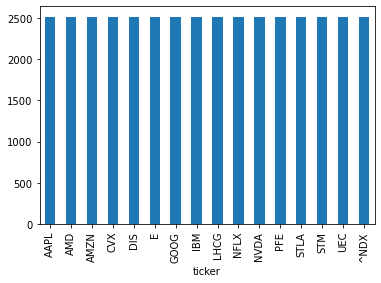

In [42]:
all_stock_df.groupby('ticker').Close.count().sort_values().plot.bar()

ticker
AAPL    AxesSubplot(0.125,0.2;0.775x0.68)
AMD     AxesSubplot(0.125,0.2;0.775x0.68)
AMZN    AxesSubplot(0.125,0.2;0.775x0.68)
CVX     AxesSubplot(0.125,0.2;0.775x0.68)
DIS     AxesSubplot(0.125,0.2;0.775x0.68)
E       AxesSubplot(0.125,0.2;0.775x0.68)
GOOG    AxesSubplot(0.125,0.2;0.775x0.68)
IBM     AxesSubplot(0.125,0.2;0.775x0.68)
LHCG    AxesSubplot(0.125,0.2;0.775x0.68)
NFLX    AxesSubplot(0.125,0.2;0.775x0.68)
NVDA    AxesSubplot(0.125,0.2;0.775x0.68)
PFE     AxesSubplot(0.125,0.2;0.775x0.68)
STLA    AxesSubplot(0.125,0.2;0.775x0.68)
STM     AxesSubplot(0.125,0.2;0.775x0.68)
UEC     AxesSubplot(0.125,0.2;0.775x0.68)
^NDX    AxesSubplot(0.125,0.2;0.775x0.68)
Name: Adj Close, dtype: object

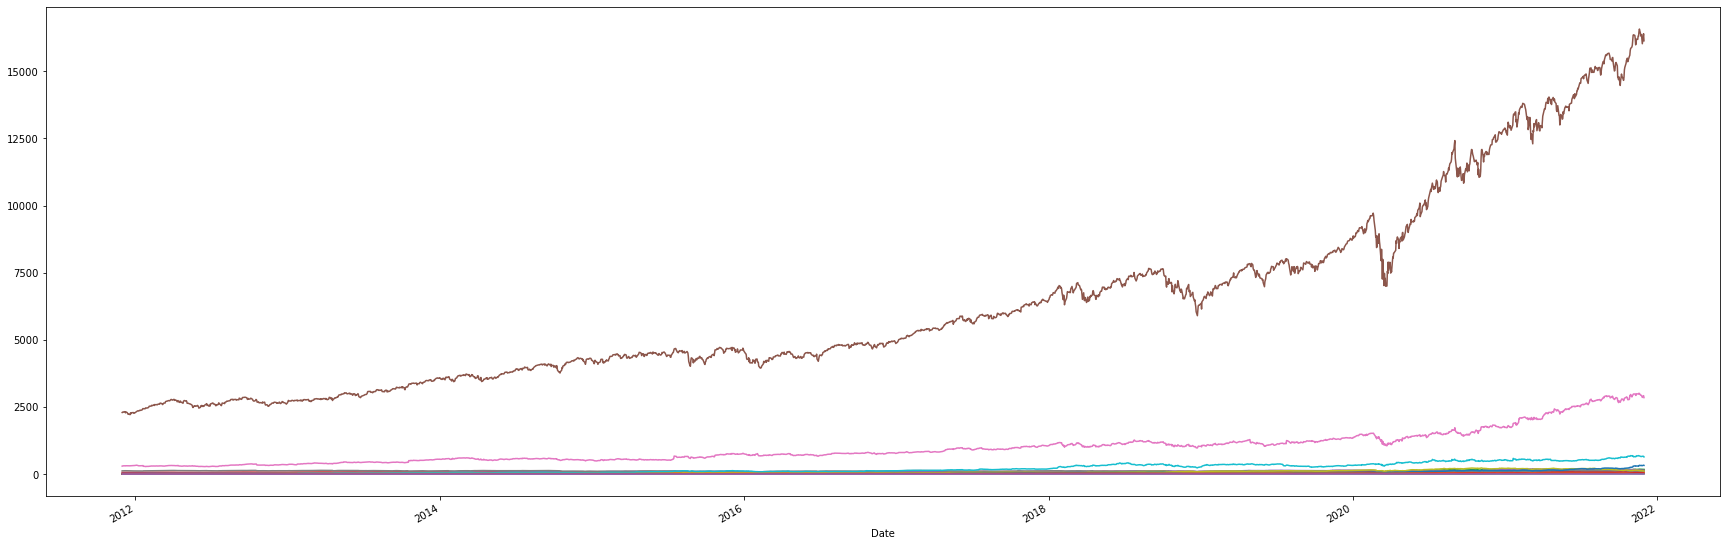

In [43]:
all_stock_df.groupby('ticker')["Adj Close"].plot(figsize=(30, 10))

In [44]:
all_stock_df.groupby("ticker")["Adj Close"].max().sort_values()

ticker
UEC         5.490000
STLA       20.198673
E          35.356922
STM        51.897263
PFE        53.159019
CVX       115.026115
IBM       143.662140
AMD       161.910004
AAPL      164.847473
AMZN      186.570496
DIS       201.910004
LHCG      231.490005
NVDA      333.591766
NFLX      691.690002
GOOG     3014.179932
^NDX    16573.339844
Name: Adj Close, dtype: float64

## Downloading Asset Data and DF Building - Merge Mode

In [45]:
start_date = '2011-11-30'
end_date = '2021-11-30'



merged_df = pd.DataFrame()
for t in stocks_df.ticker.unique():
    if merged_df.shape[0] == 0:
        merged_df = web.get_data_yahoo(t, start_date, end_date).add_suffix('_' + str(t))
        print(t)
        print(merged_df.head())
    else:
        print(t)
        df = web.get_data_yahoo(t, start_date, end_date).add_suffix('_' + str(t))
        merged_df = merged_df.join(df)

    



merged_df.head()        

AAPL
            High_AAPL   Low_AAPL  Open_AAPL  Close_AAPL  Volume_AAPL  \
Date                                                                   
2011-11-30  13.652857  13.510714  13.617500   13.650000  405938400.0   
2011-12-01  13.892857  13.598214  13.662143   13.854643  387181200.0   
2011-12-02  14.058214  13.877857  13.922500   13.917857  379055600.0   
2011-12-05  14.157500  13.942500  14.053214   14.036071  357210000.0   
2011-12-06  14.093929  13.906429  14.018214   13.962500  283598000.0   

            Adj Close_AAPL  
Date                        
2011-11-30       11.670994  
2011-12-01       11.845966  
2011-12-02       11.900016  
2011-12-05       12.001092  
2011-12-06       11.938188  
IBM
GOOG
AMZN
NVDA
AMD
NFLX
E
STLA
STM
PFE
DIS
LHCG
CVX
UEC
^NDX


High_AAPL   Low_AAPL  Open_AAPL  Close_AAPL  Volume_AAPL  \
Date                                                                   
2011-11-30  13.652857  13.510714  13.617500   13.650000  405938400.0   
2011-12-01  13.892857  13.598214  13.662143   13.854643  387181200.0   
2011-12-02  14.058214  13.877857  13.922500   13.917857  379055600.0   
2011-12-05  14.157500  13.942500  14.053214   14.036071  357210000.0   
2011-12-06  14.093929  13.906429  14.018214   13.962500  283598000.0   

            Adj Close_AAPL    High_IBM     Low_IBM    Open_IBM   Close_IBM  \
Date                                                                         
2011-11-30       11.670994  180.066925  176.108994  176.453156  179.732315   
2011-12-01       11.845966  181.634796  178.556412  178.785858  181.118546   
2011-12-02       11.900016  182.915863  181.118546  181.567871  181.319305   
2011-12-05       12.001092  185.095596  182.007645  182.772461  182.447418   
2011-12-06       11.938188  185.019119  181.950287  182.265778  184.455063   

            ...  Open_UEC  Close_UEC  Volume_UEC  Adj Close_UEC    High_^NDX  \
Date        ...                                                                
2011-11-30  ...      2.85       3.05      610900           3.05  2295.350098   
2011-12-01  ...      3.02       2.89      362700           2.89  2314.899902   
2011-12-02  ...      2.99       2.92      322000           2.92  2331.120117   
2011-12-05  ...      2.95       3.04      353500           3.04  2343.100098   
2011-12-06  ...      2.93       3.06      343600           3.06  2335.790039   

               Low_^NDX    Open_^NDX   Close_^NDX  Volume_^NDX  Adj Close_^NDX  
Date                                                                            
2011-11-30  2264.719971  2270.280029  2295.199951   2440960000     2295.199951  
2011-12-01  2292.260010  2294.270020  2309.199951   1826860000     2309.199951  
2011-12-02  2301.250000  2327.870117  2302.040039   1662730000     2302.040039  
2011-12-05  2315.179932  2336.550049  2326.949951   1686660000     2326.949951  
2011-12-06  2313.989990  2327.649902  2321.489990   1491130000     2321.489990  

[5 rows x 96 columns]

<AxesSubplot:xlabel='Date'>

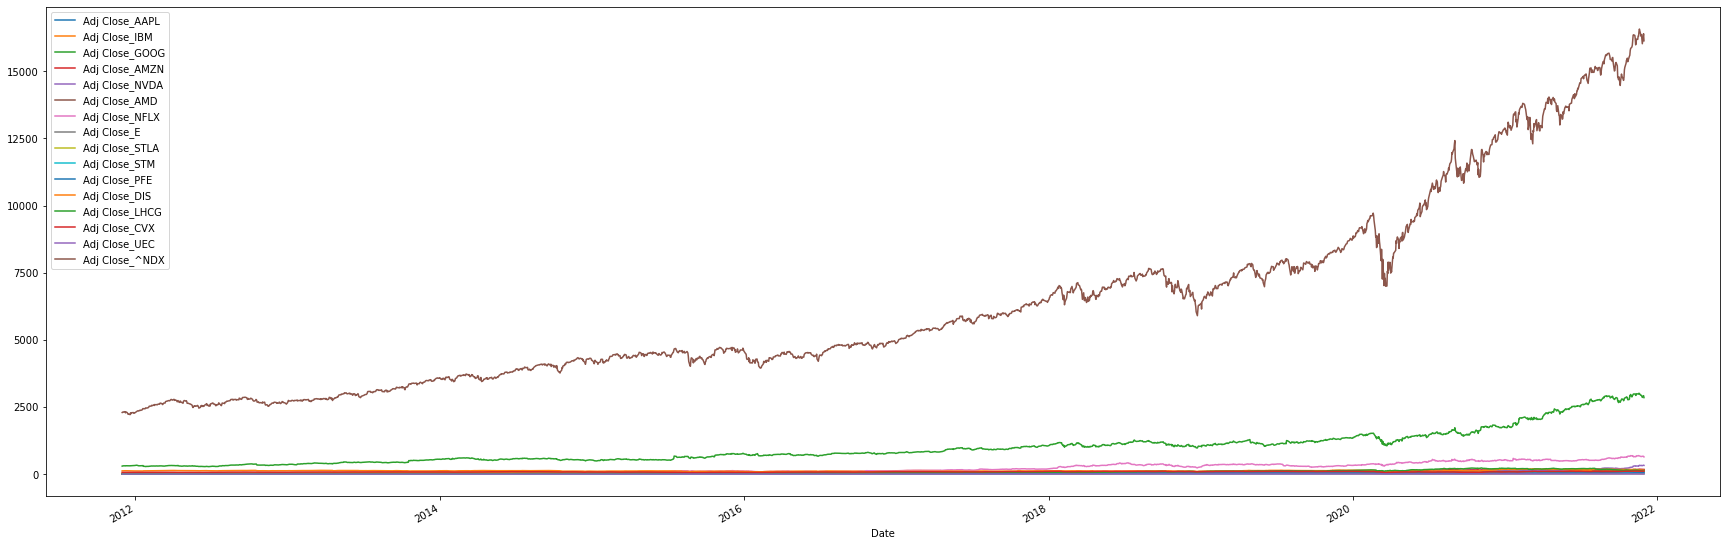

In [46]:

adj_close_columns = [col for col in merged_df.columns if "Adj Close" in col]
merged_df[adj_close_columns].plot(figsize=(30, 10))


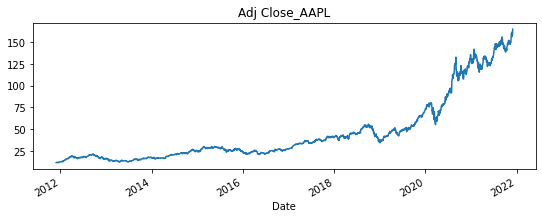

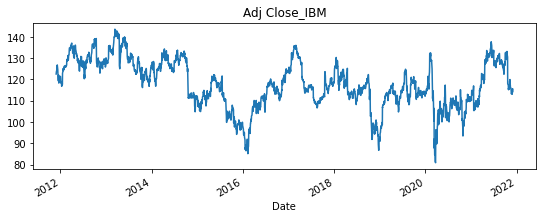

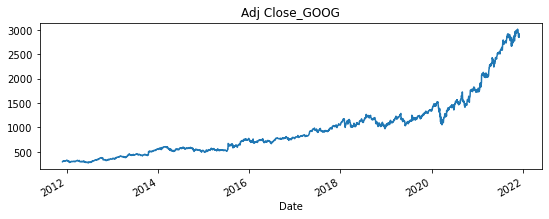

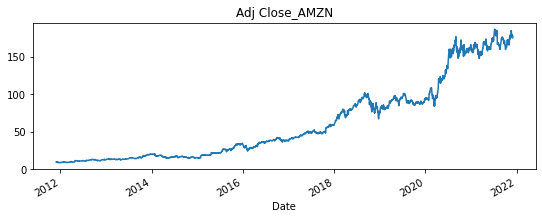

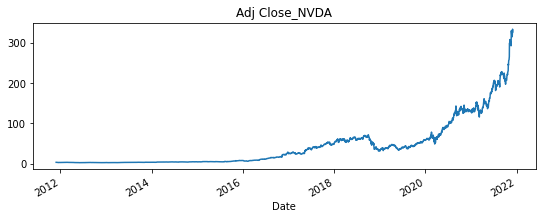

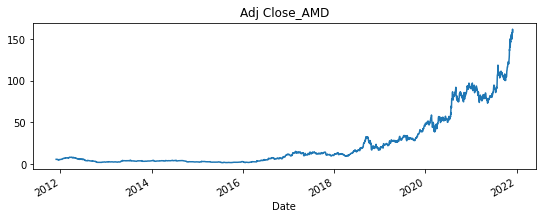

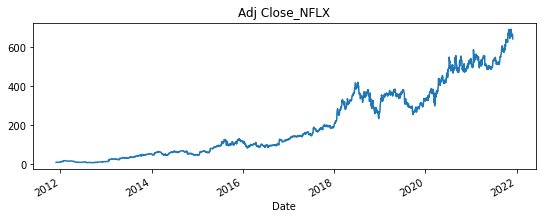

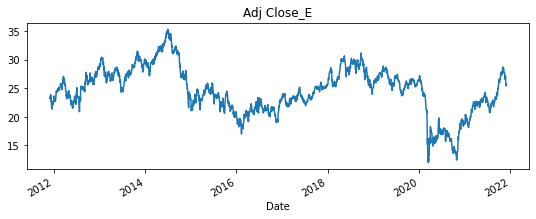

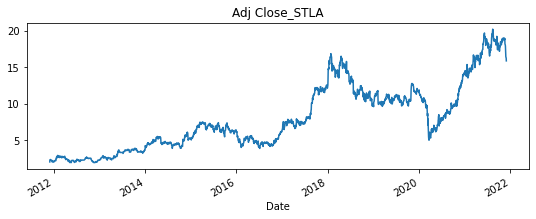

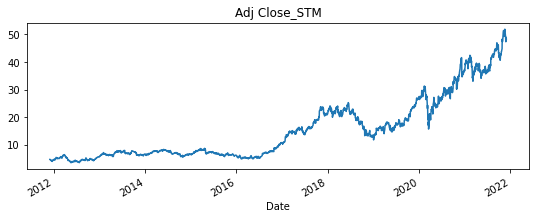

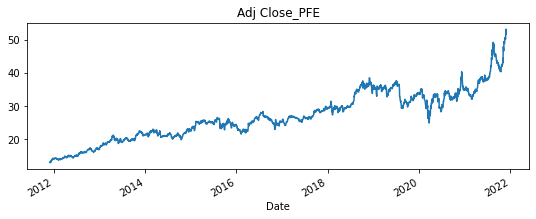

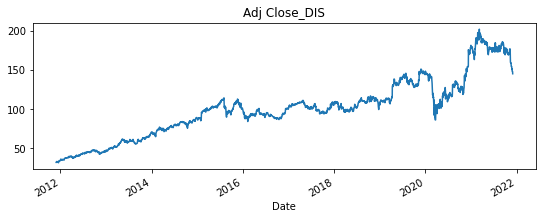

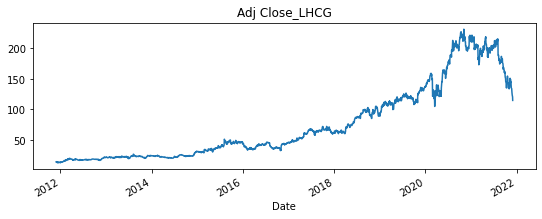

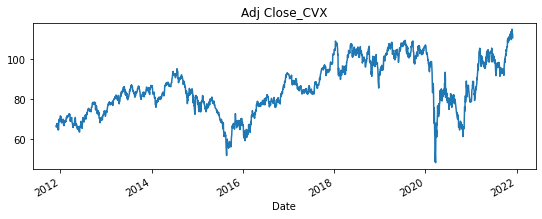

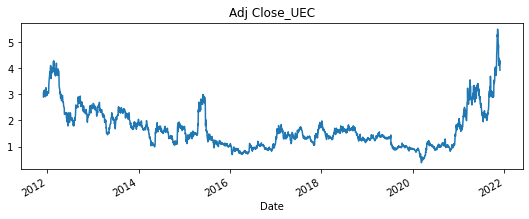

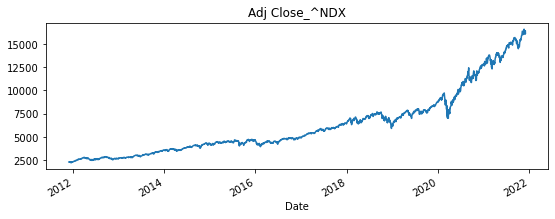

In [47]:
for col in adj_close_columns:
    merged_df[col].plot(figsize=(9, 3))
    plt.title(col)
    plt.show()


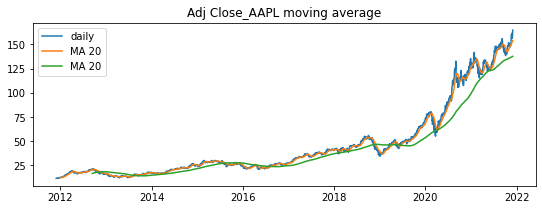

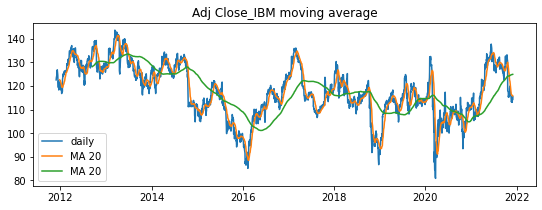

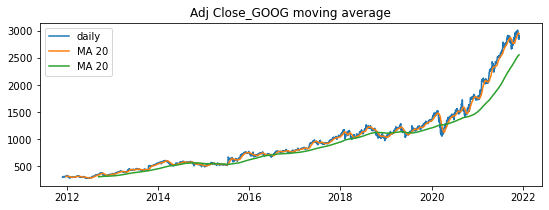

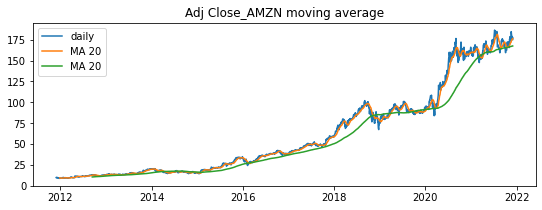

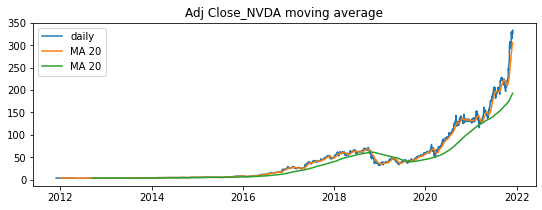

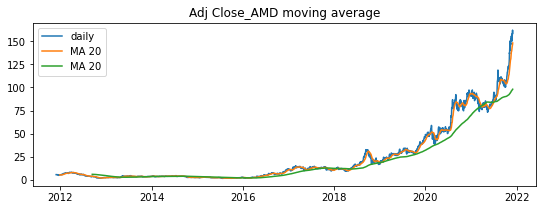

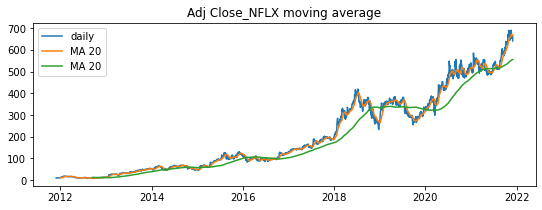

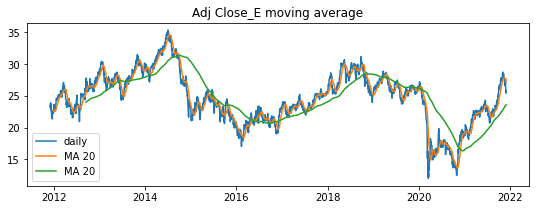

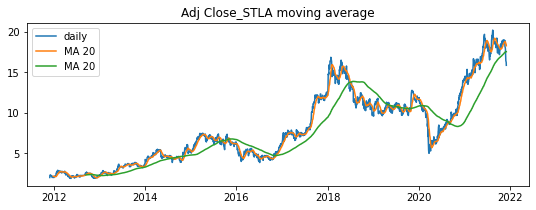

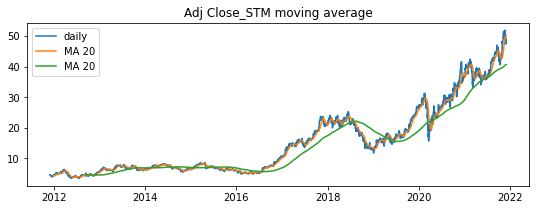

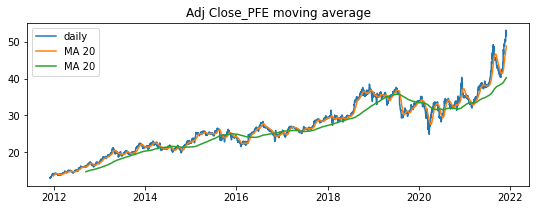

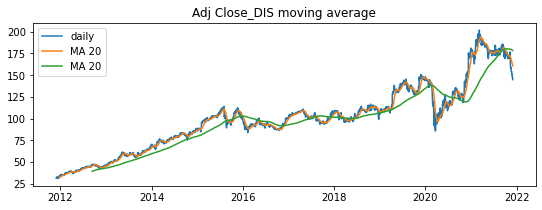

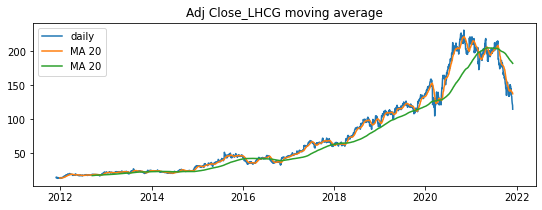

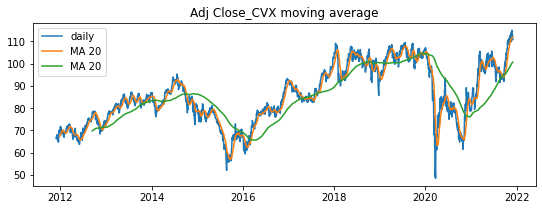

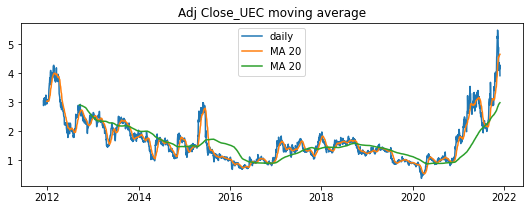

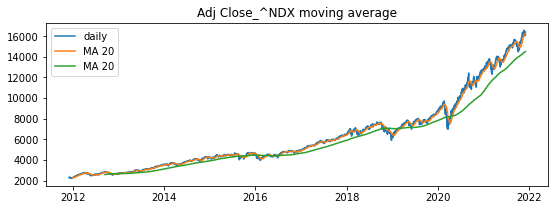

In [104]:
for col in adj_close_columns:
    plt.figure(figsize=(9, 3))
    plt.plot(merged_df[col], label="daily")
    plt.plot(merged_df[col].rolling(20).mean(), label="MA 20")  # rolling(days)
    plt.plot(merged_df[col].rolling(200).mean(), label="MA 20")
    plt.legend(loc="best")
    plt.title(f"{col} moving average")
    plt.show()

<AxesSubplot:xlabel='ticker'>

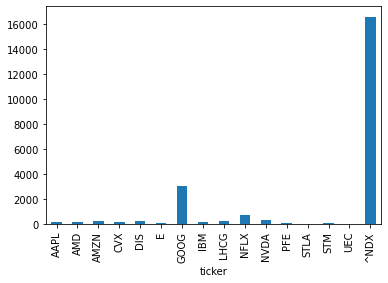

In [48]:
all_stock_df.groupby('ticker')['Adj Close'].max().plot.bar()

## YIELDS COMPUTATION

In [50]:
# LOG( ritorno di oggi / ritorno di ieri)

merged_yield = pd.DataFrame()

for t in stocks_df.ticker.unique():
    
    col = f"Adj Close_{t}"
    print(col)

    merged_yield[t] = np.log( merged_df[col] / merged_df[col].shift(1) ).dropna()



Adj Close_AAPL
Adj Close_IBM
Adj Close_GOOG
Adj Close_AMZN
Adj Close_NVDA
Adj Close_AMD
Adj Close_NFLX
Adj Close_E
Adj Close_STLA
Adj Close_STM
Adj Close_PFE
Adj Close_DIS
Adj Close_LHCG
Adj Close_CVX
Adj Close_UEC
Adj Close_^NDX


In [51]:
merged_yield.head()

AAPL       IBM      GOOG      AMZN      NVDA       AMD  \
Date                                                                     
2011-12-01  0.014881  0.007683  0.023708  0.024859  0.012083  0.001756   
2011-12-02  0.004552  0.001108  0.010680 -0.005596 -0.006341 -0.008811   
2011-12-05  0.008458  0.006202  0.008491  0.001071 -0.015385  0.019282   
2011-12-06 -0.005255  0.010944 -0.003009 -0.021895 -0.014314 -0.017514   
2011-12-07 -0.004769  0.005737 -0.000609  0.017196 -0.005915  0.010545   

                NFLX         E      STLA       STM       PFE       DIS  \
Date                                                                     
2011-12-01  0.040096  0.000000  0.129077  0.001579 -0.001995  0.003897   
2011-12-02 -0.011981 -0.000235  0.001951 -0.003160 -0.007014  0.017081   
2011-12-05  0.054963  0.018443  0.023122 -0.009539 -0.002517  0.008973   
2011-12-06 -0.028644  0.006686  0.000000 -0.001599  0.019467 -0.002982   
2011-12-07  0.054546  0.001148 -0.021175 -0.011263  0.011794  0.007304   

                LHCG       CVX       UEC      ^NDX  
Date                                                
2011-12-01  0.002156 -0.009675 -0.053885  0.006081  
2011-12-02  0.024115 -0.001376  0.010327 -0.003105  
2011-12-05 -0.014826  0.011051  0.040274  0.010763  
2011-12-06 -0.030327  0.014866  0.006557 -0.002349  
2011-12-07  0.033877  0.001532  0.025808 -0.000409

<AxesSubplot:>

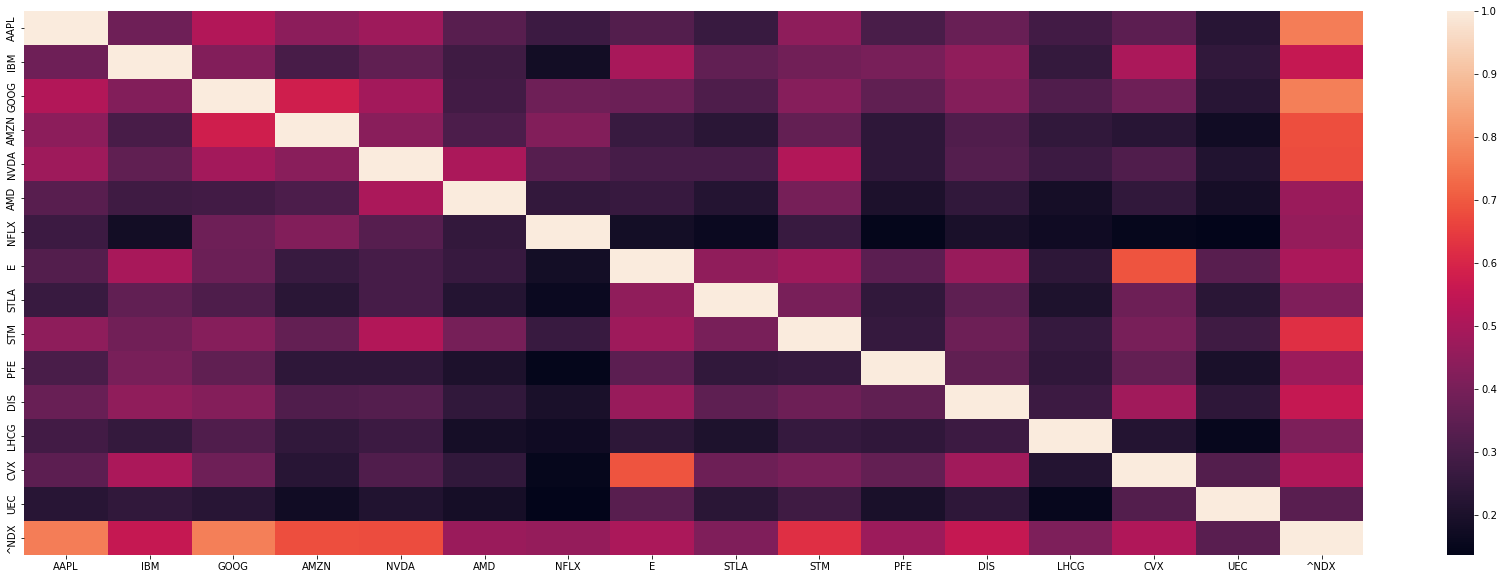

In [85]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(merged_yield.corr())


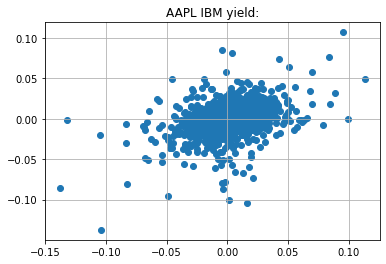

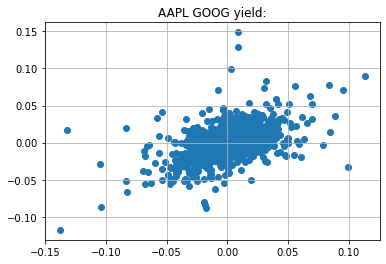

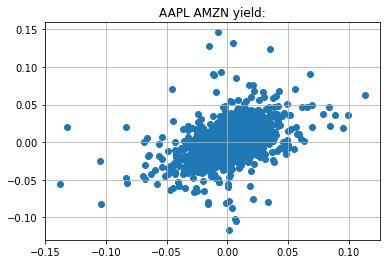

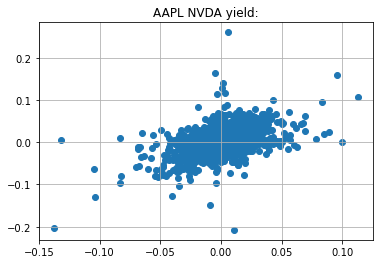

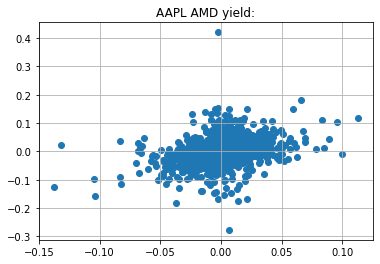

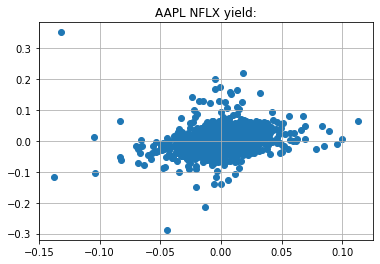

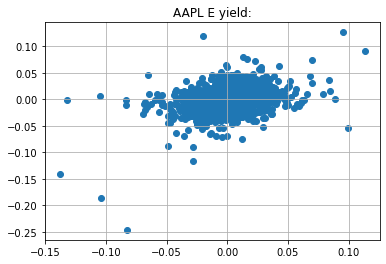

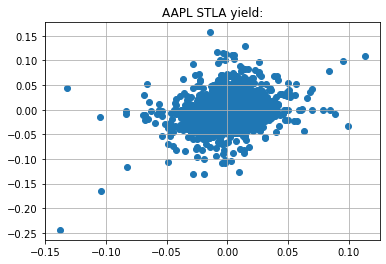

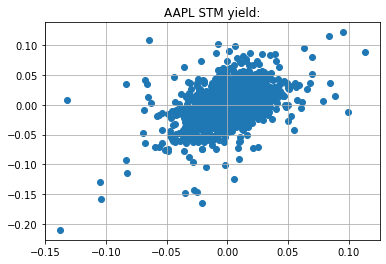

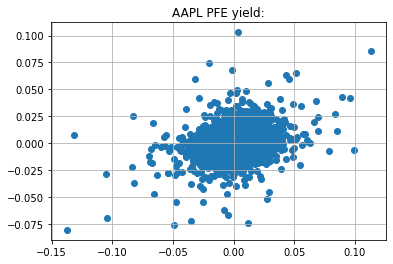

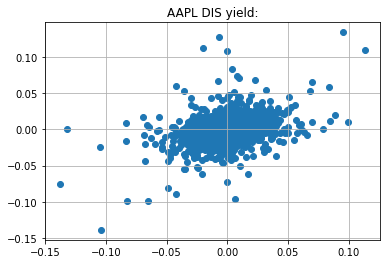

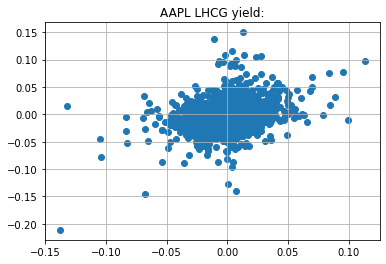

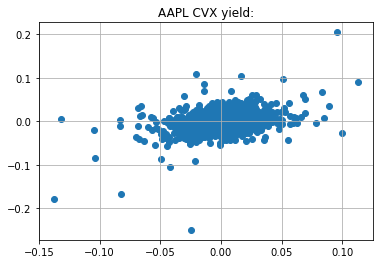

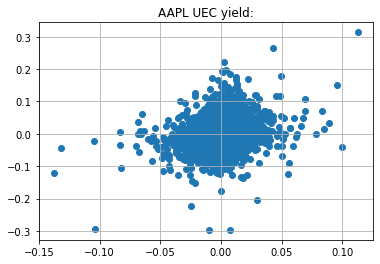

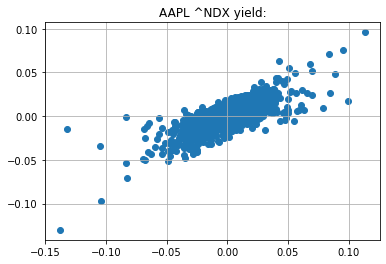

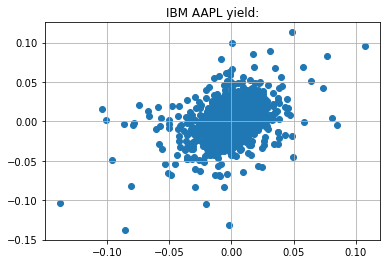

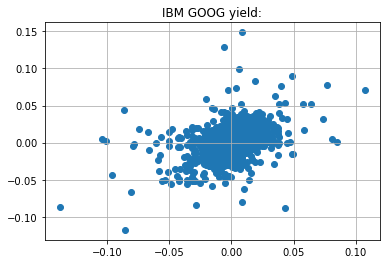

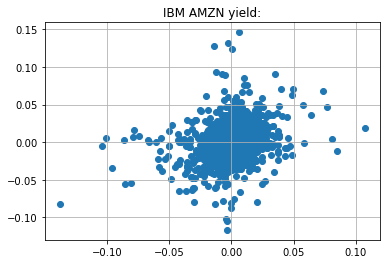

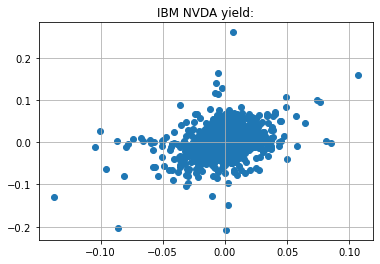

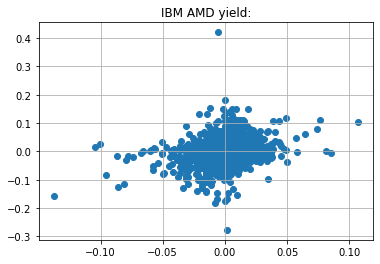

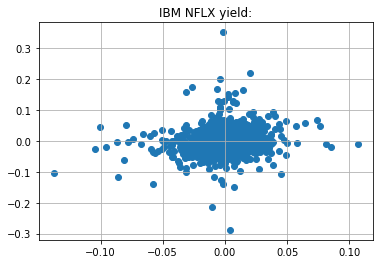

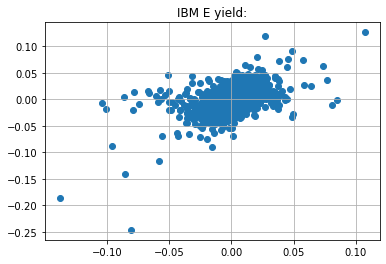

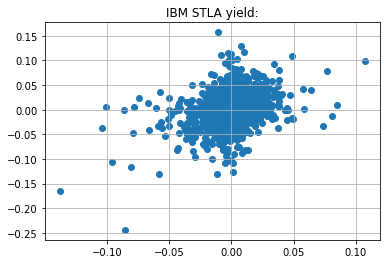

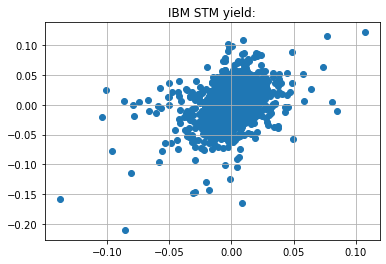

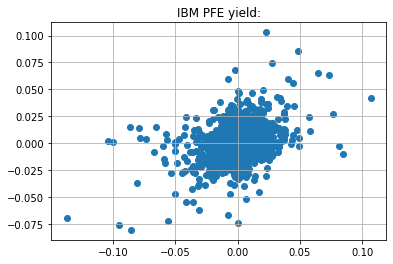

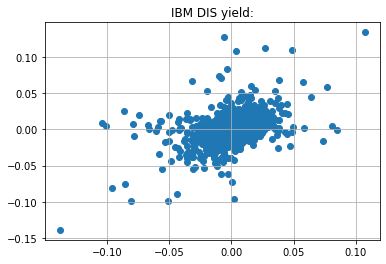

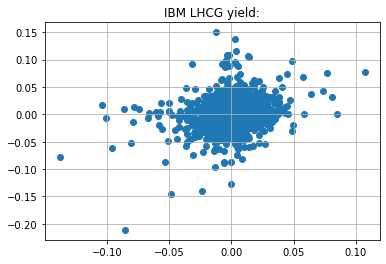

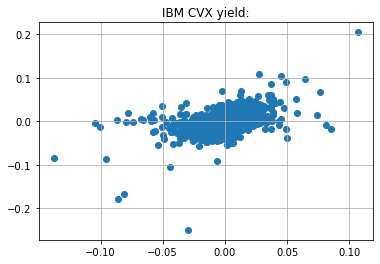

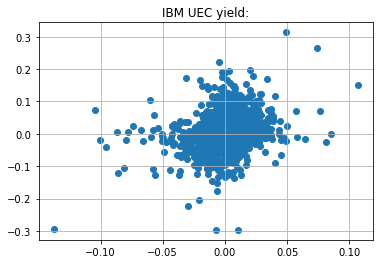

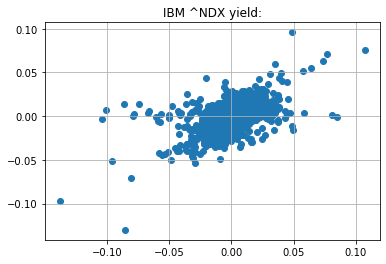

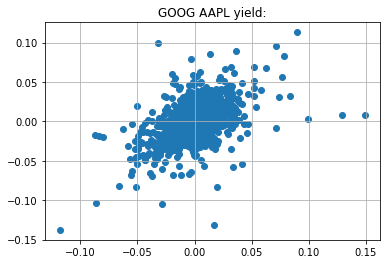

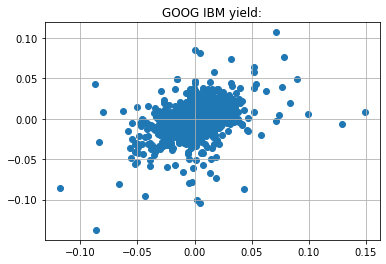

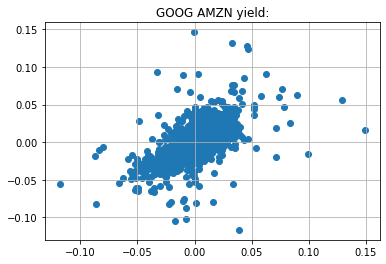

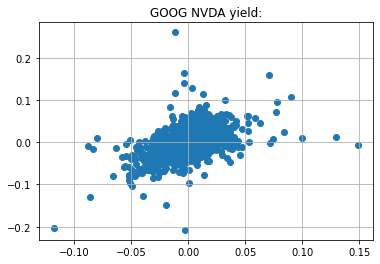

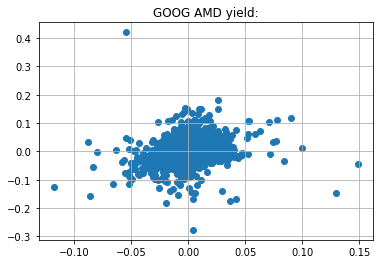

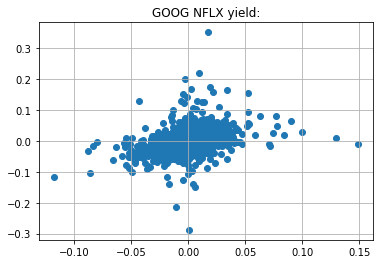

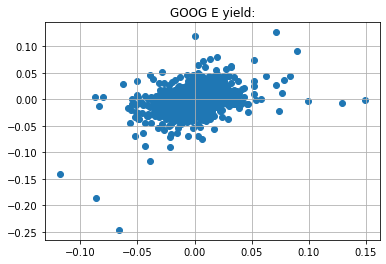

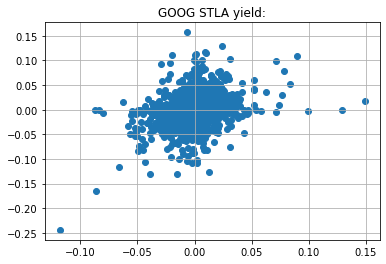

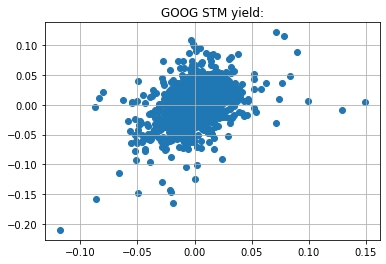

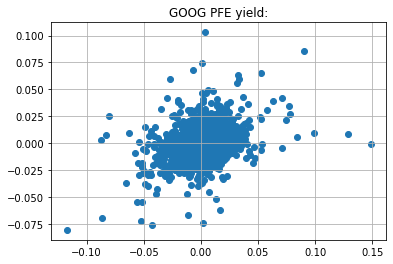

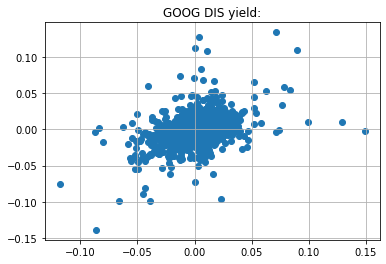

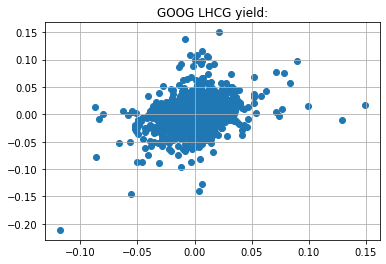

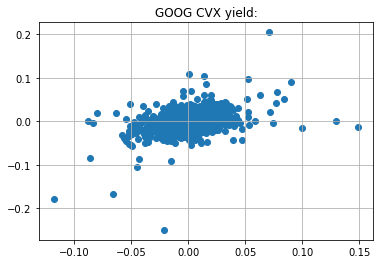

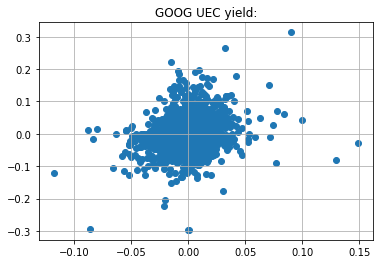

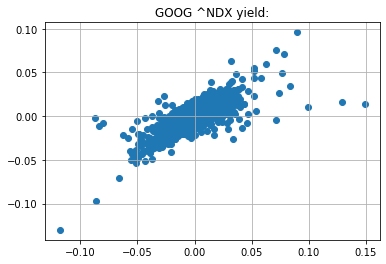

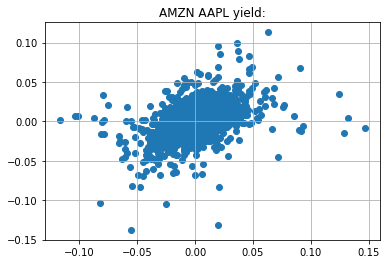

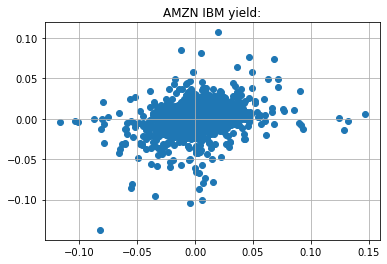

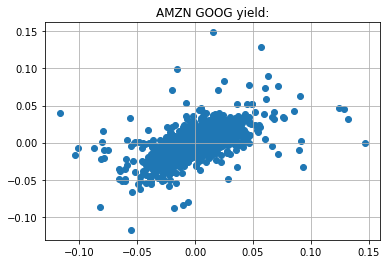

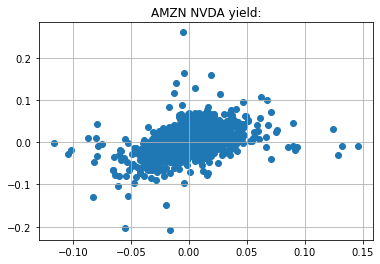

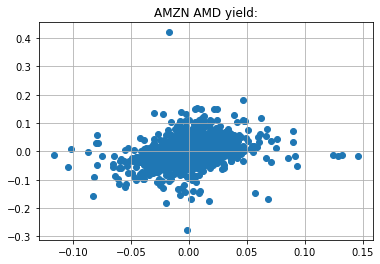

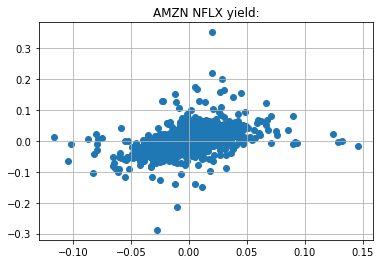

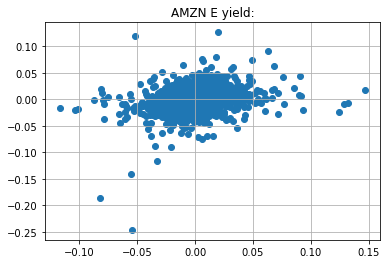

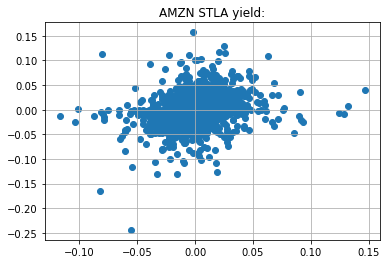

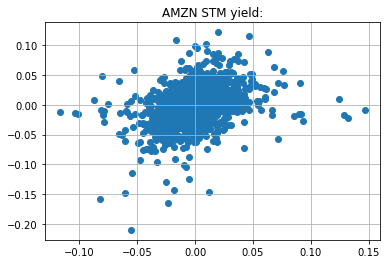

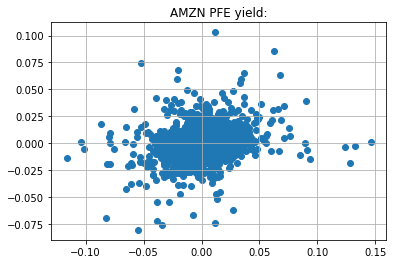

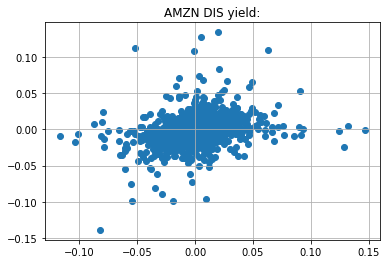

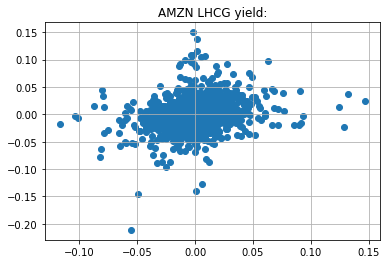

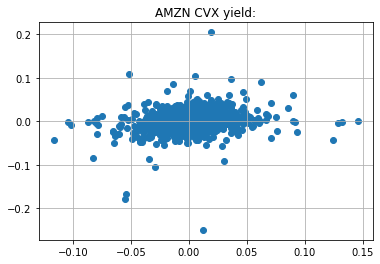

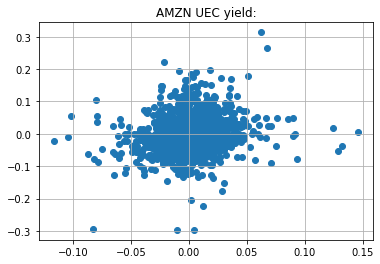

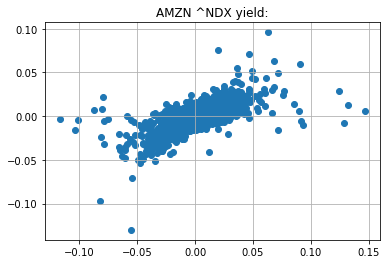

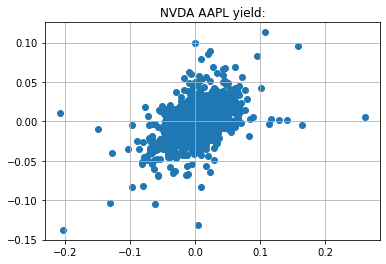

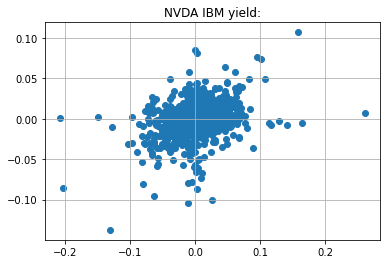

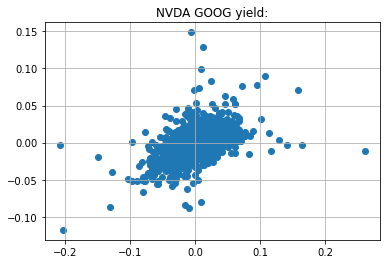

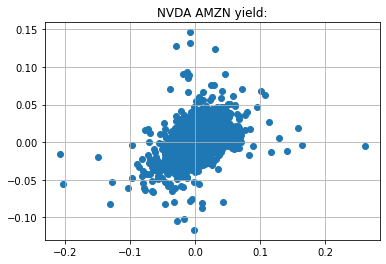

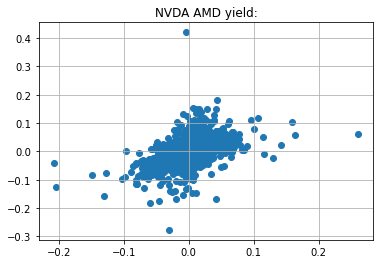

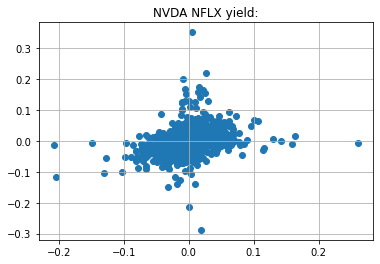

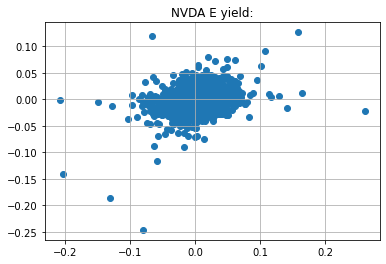

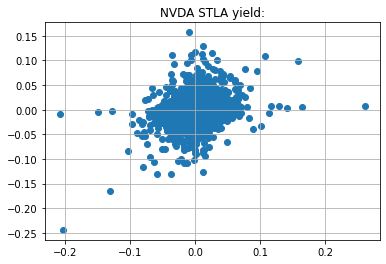

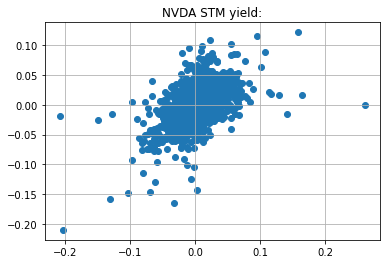

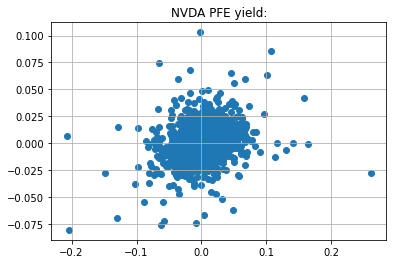

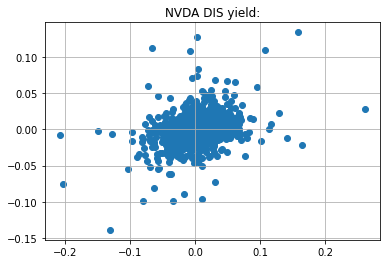

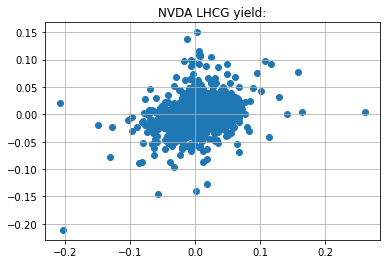

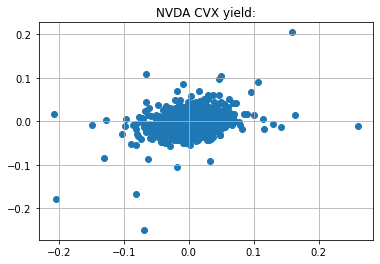

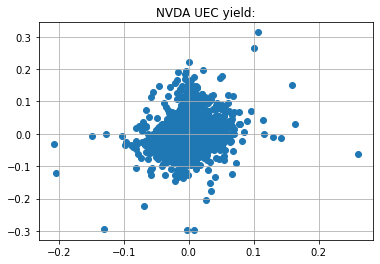

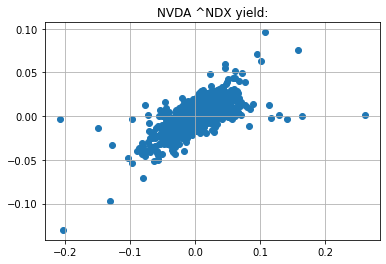

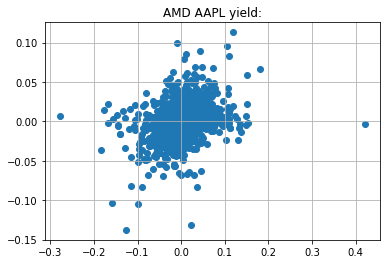

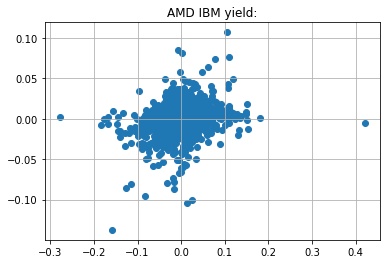

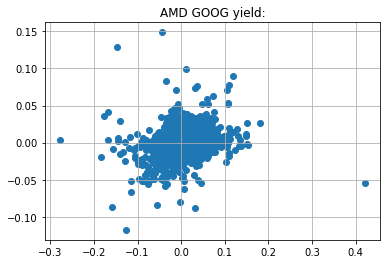

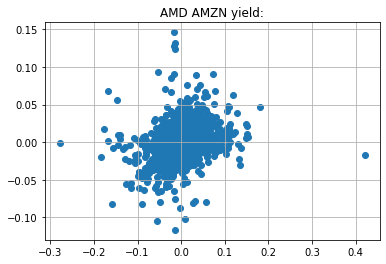

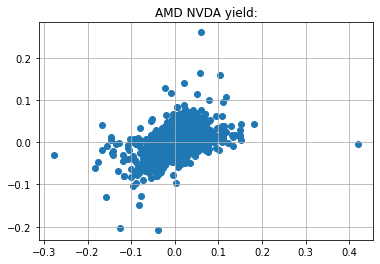

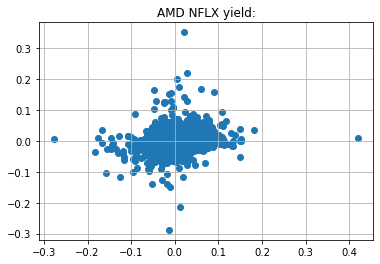

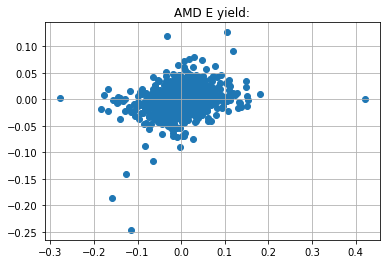

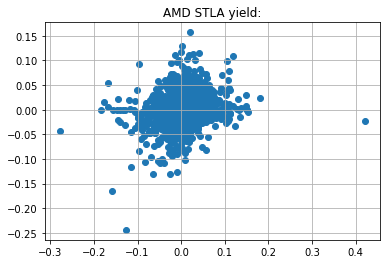

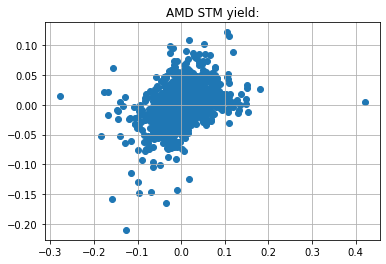

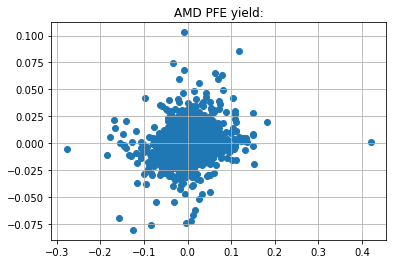

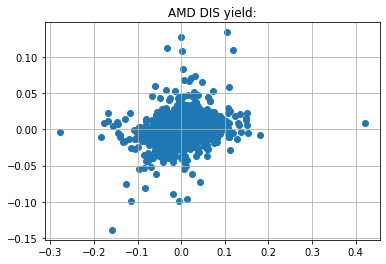

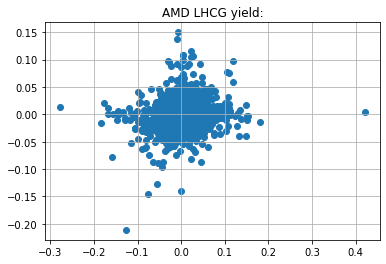

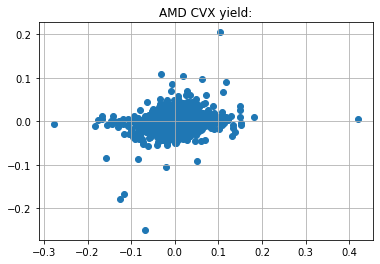

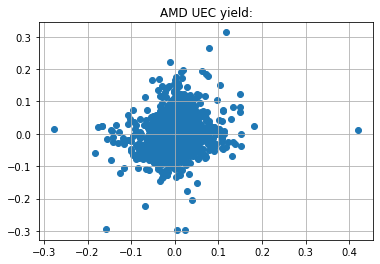

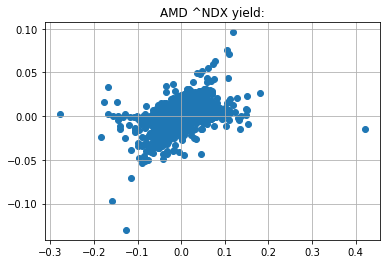

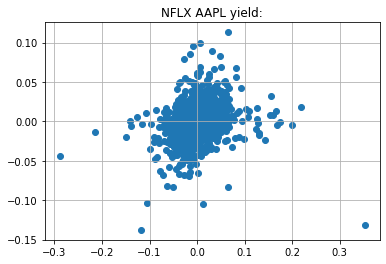

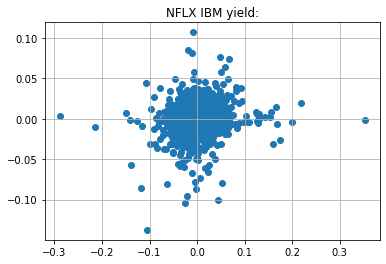

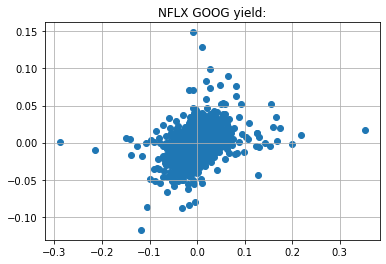

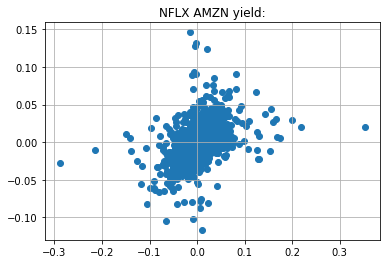

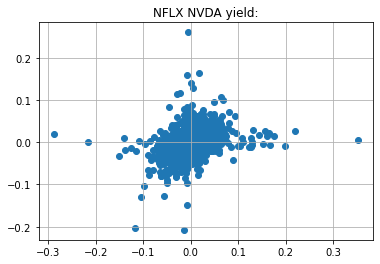

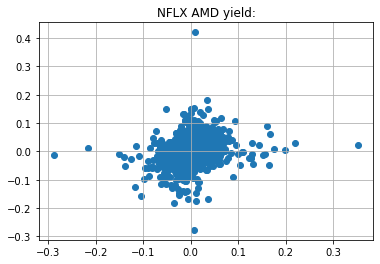

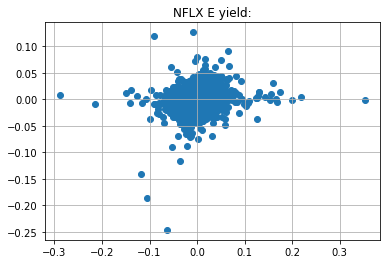

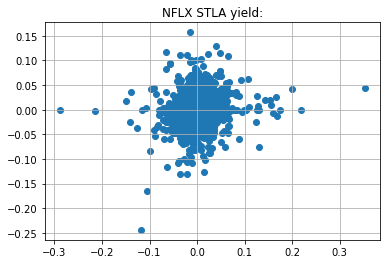

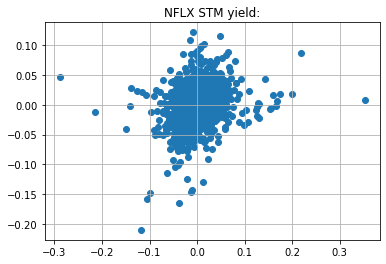

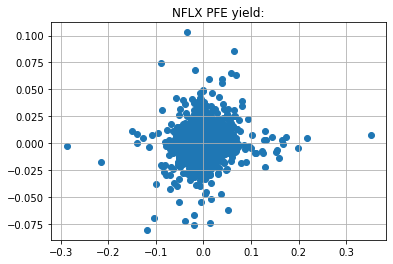

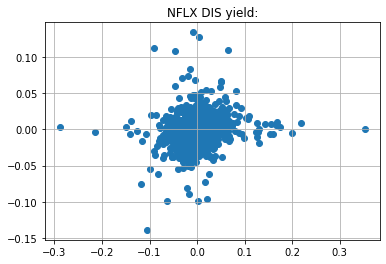

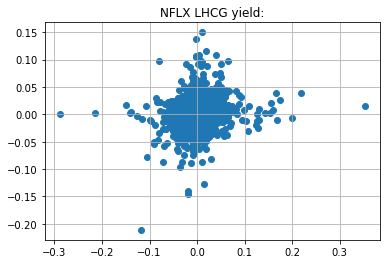

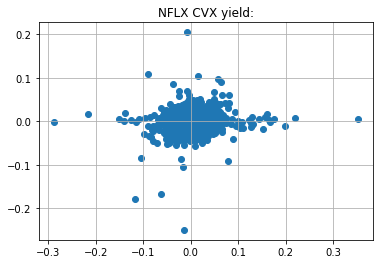

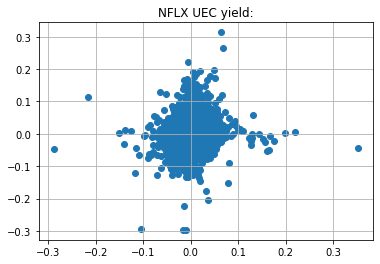

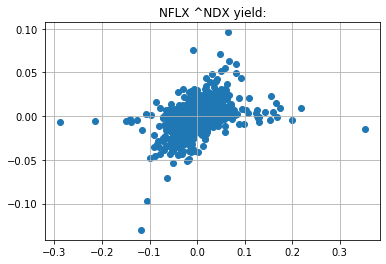

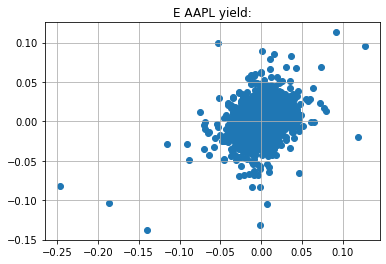

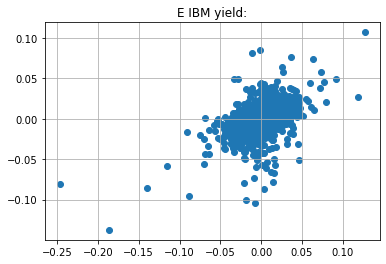

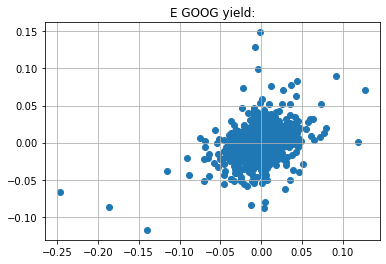

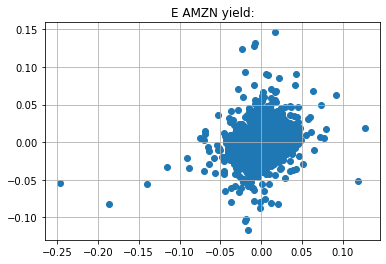

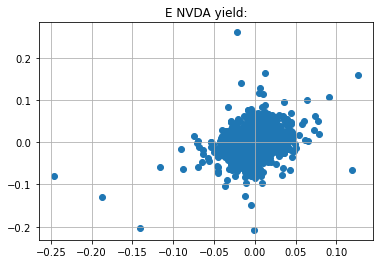

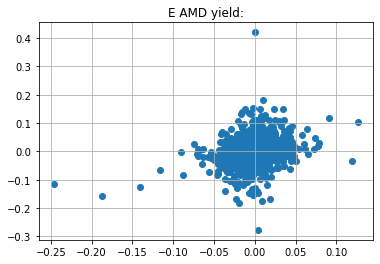

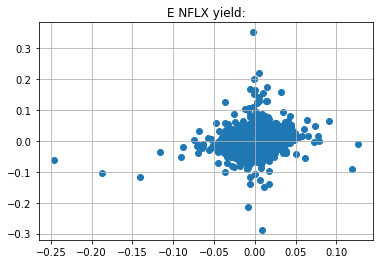

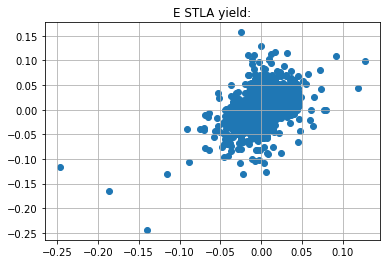

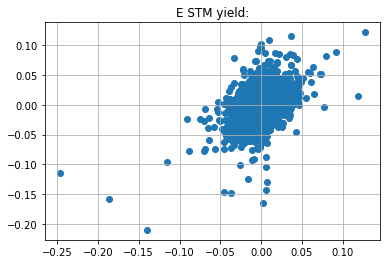

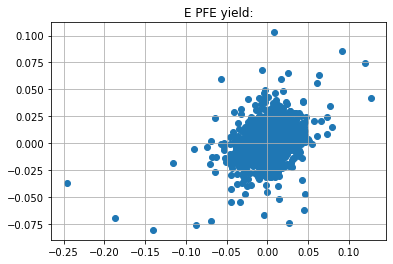

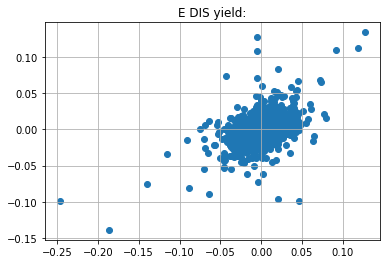

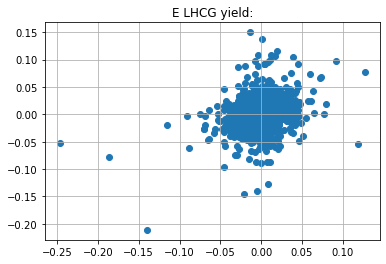

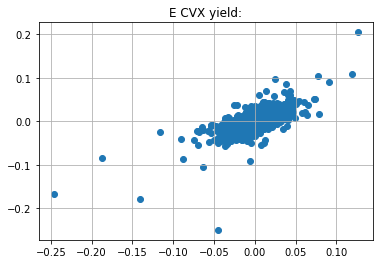

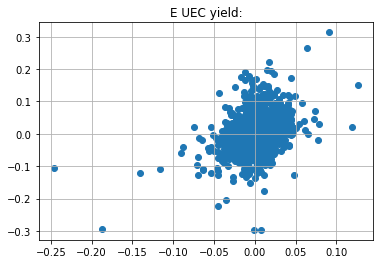

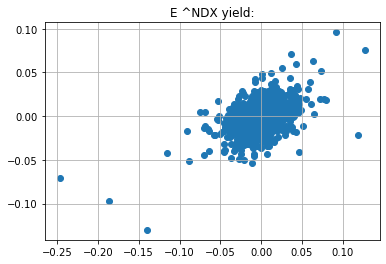

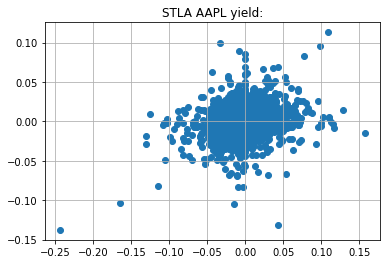

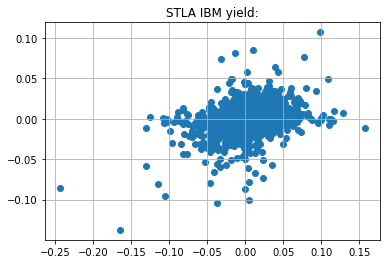

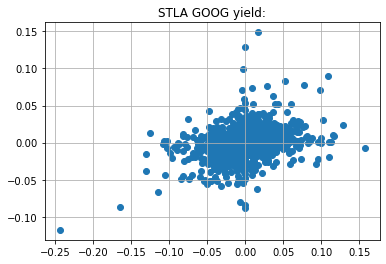

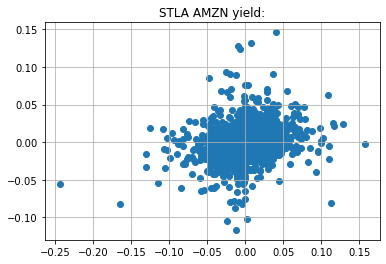

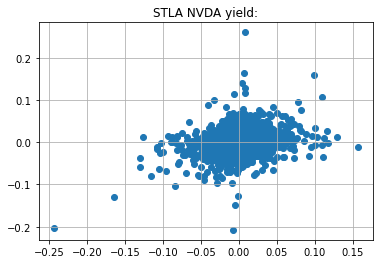

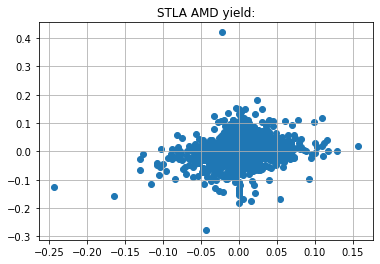

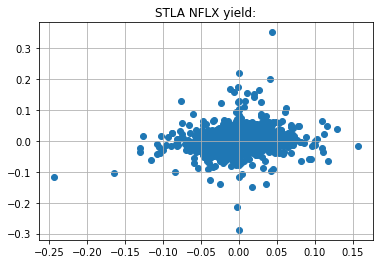

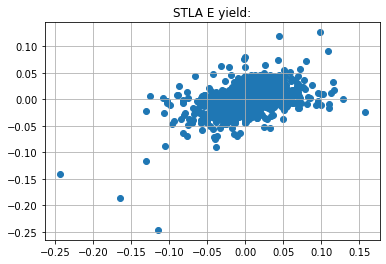

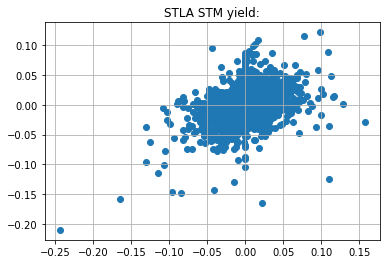

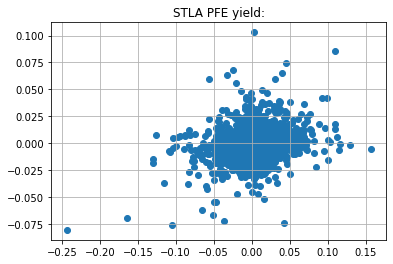

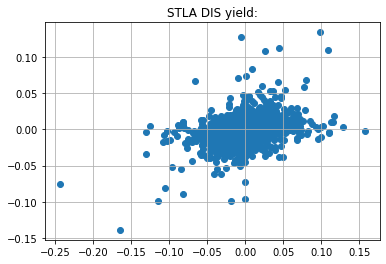

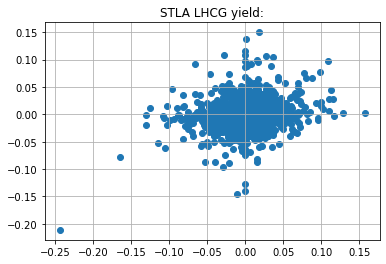

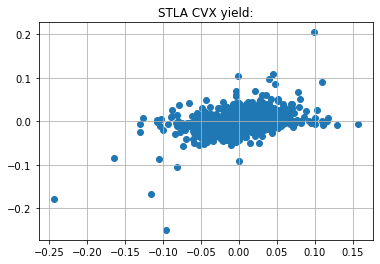

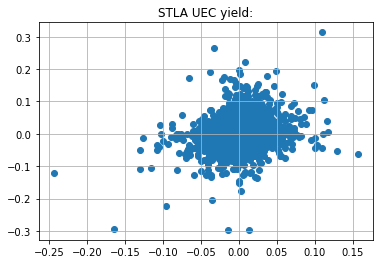

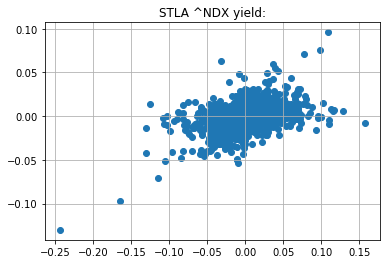

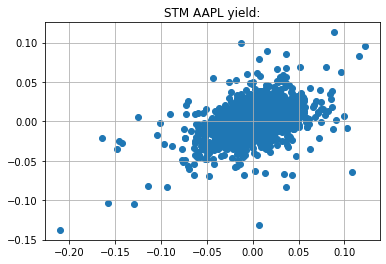

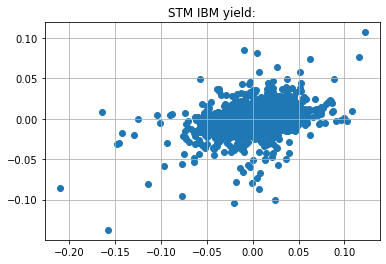

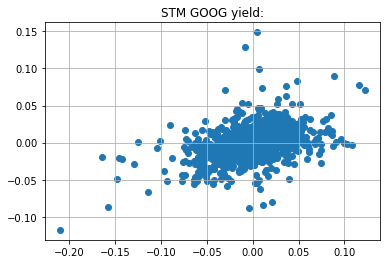

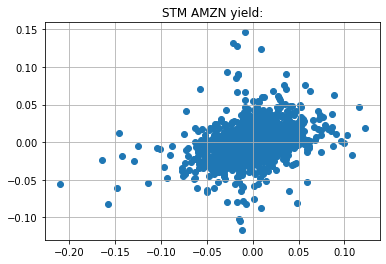

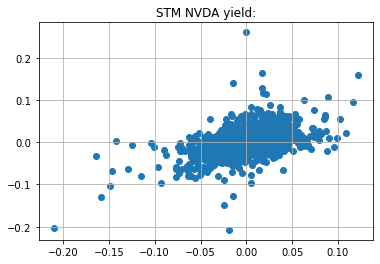

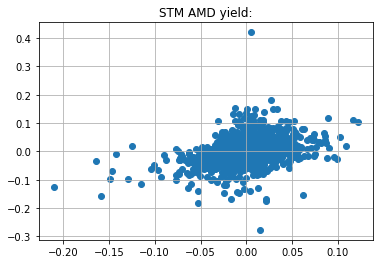

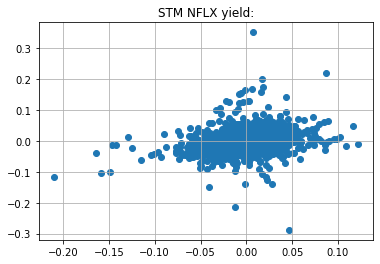

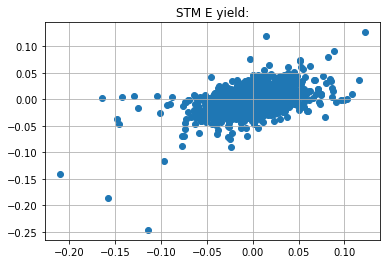

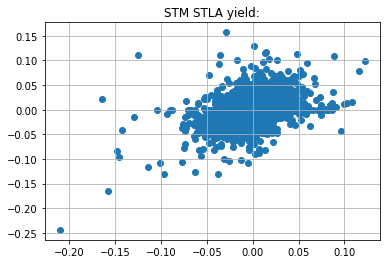

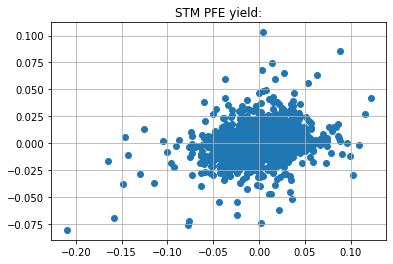

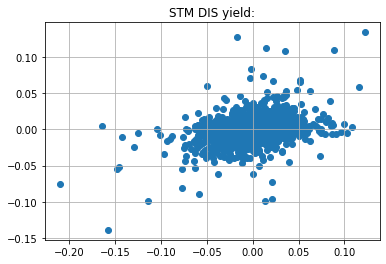

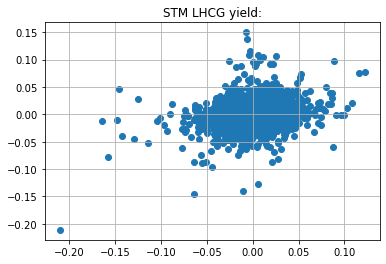

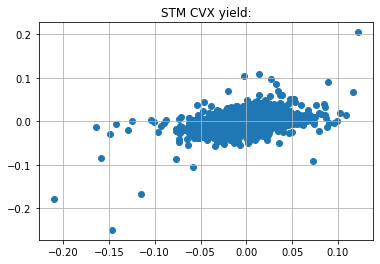

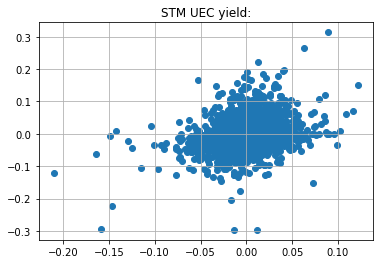

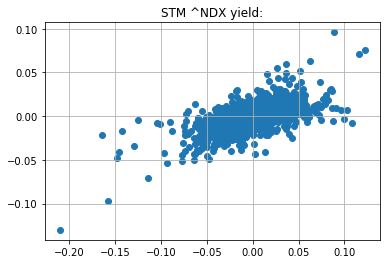

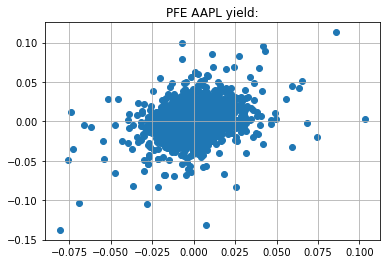

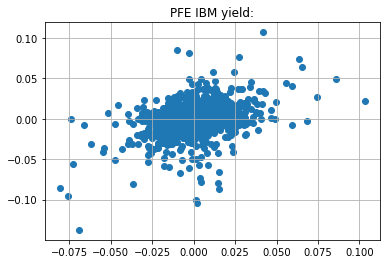

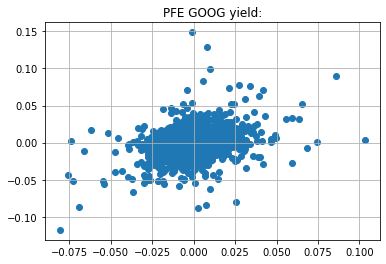

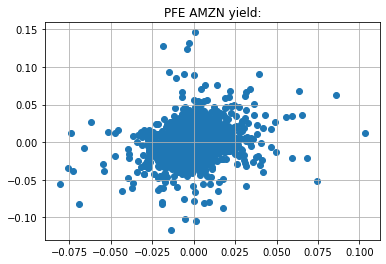

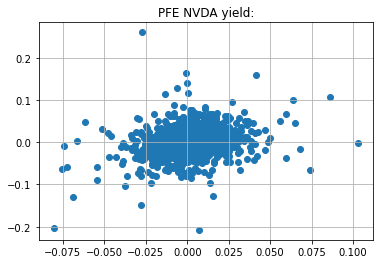

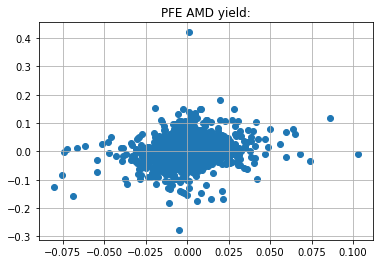

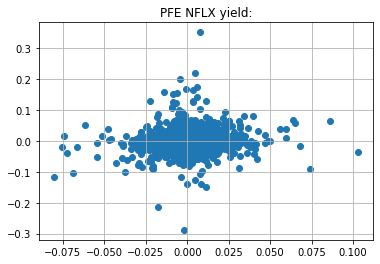

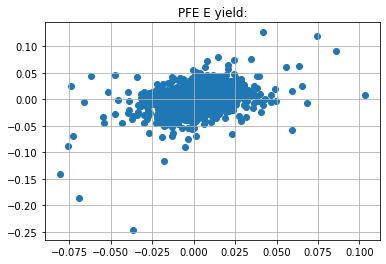

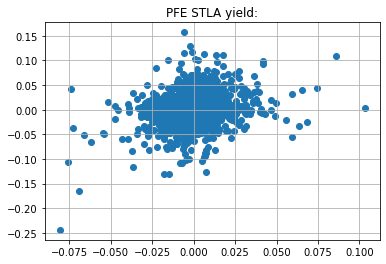

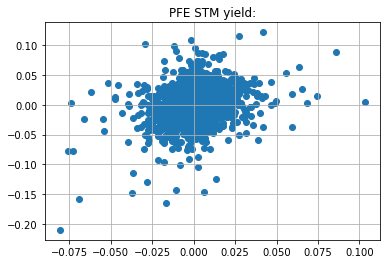

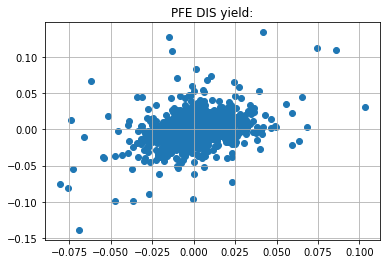

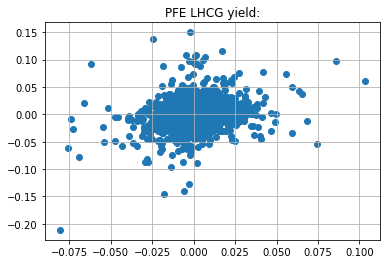

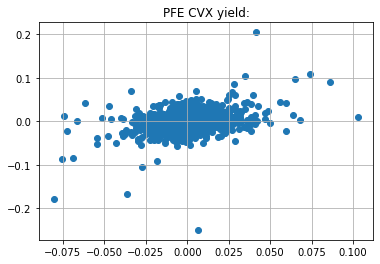

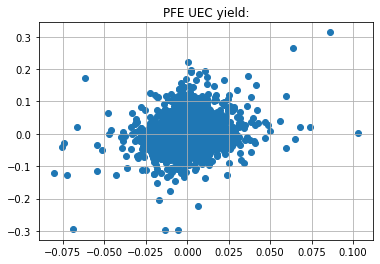

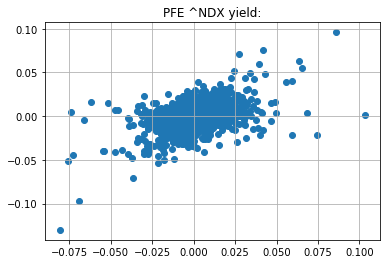

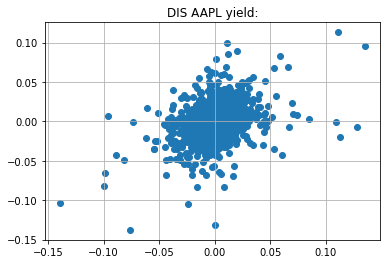

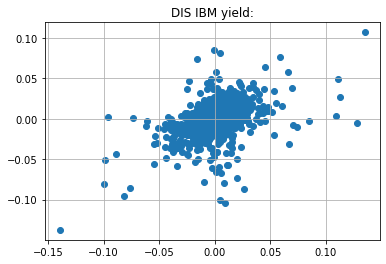

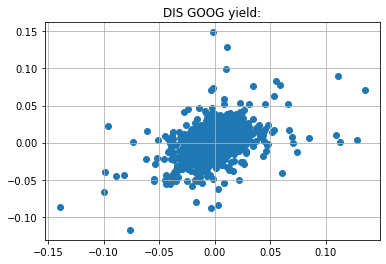

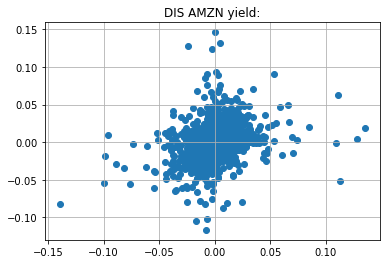

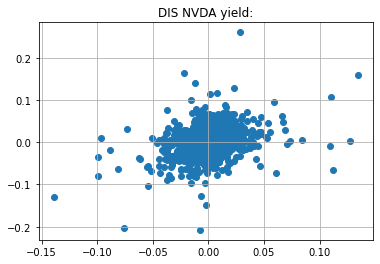

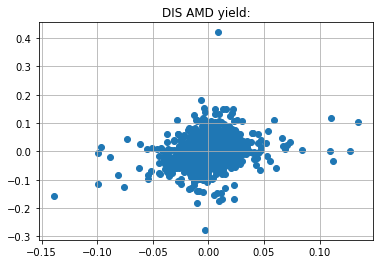

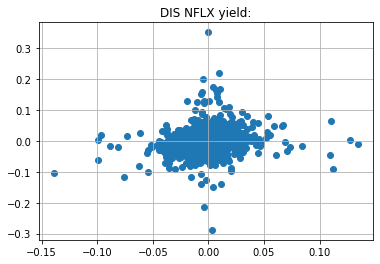

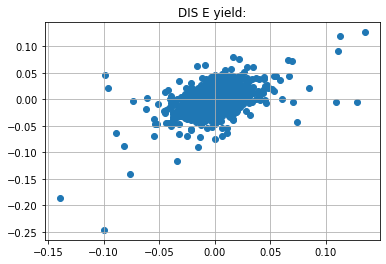

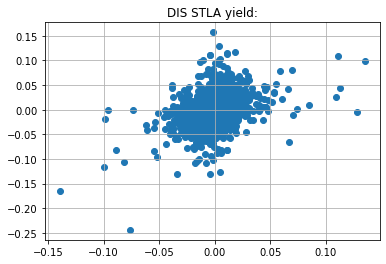

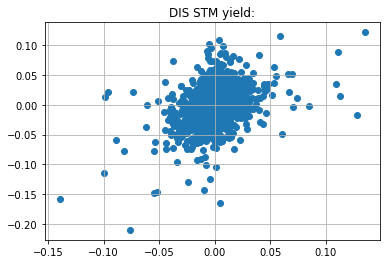

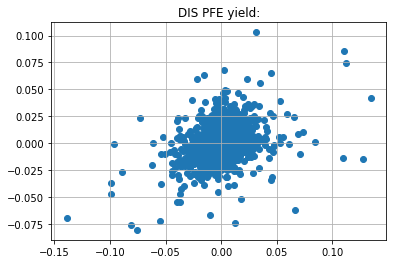

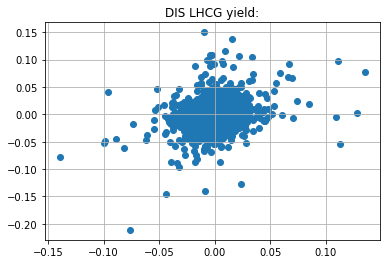

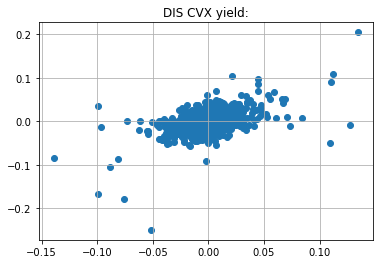

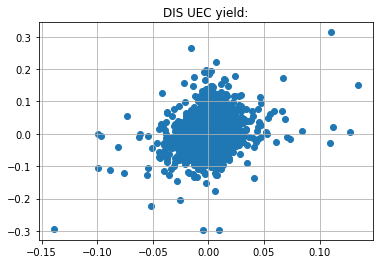

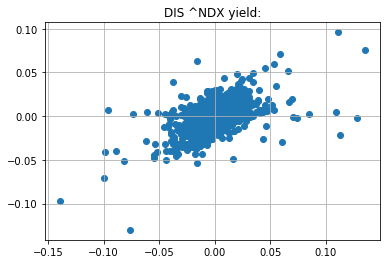

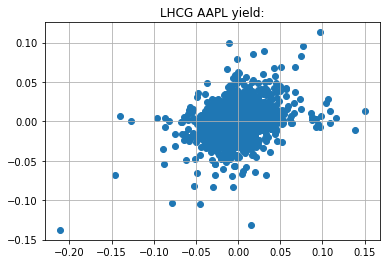

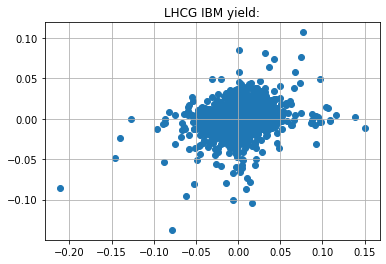

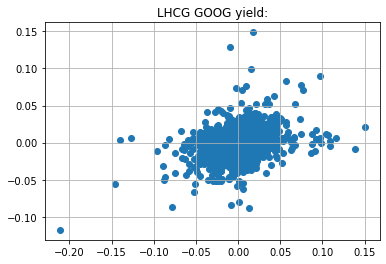

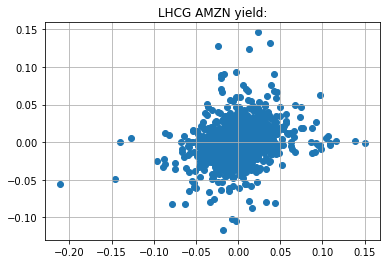

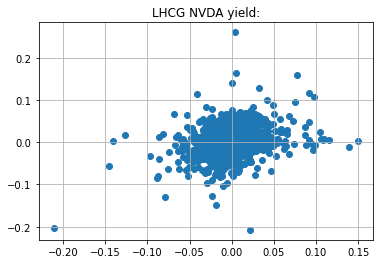

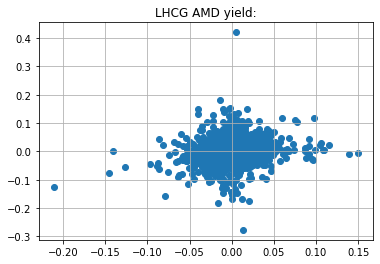

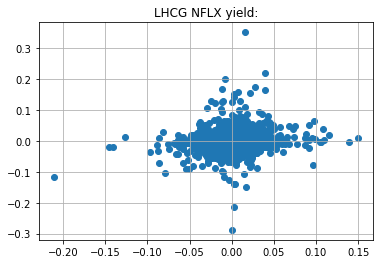

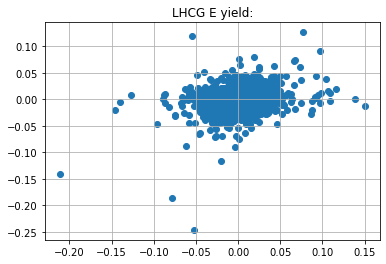

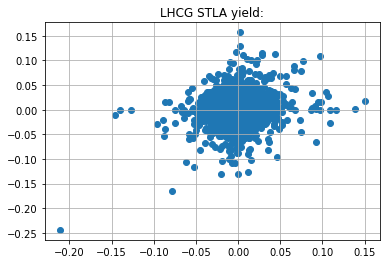

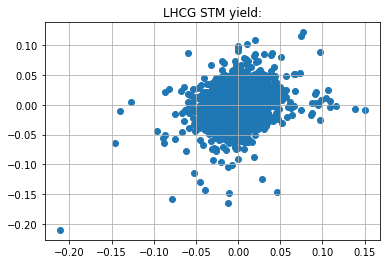

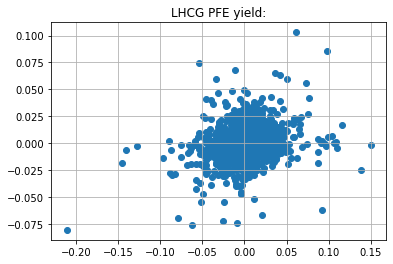

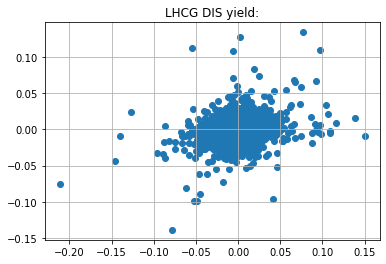

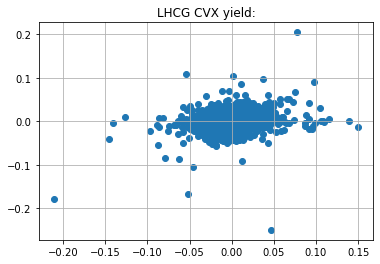

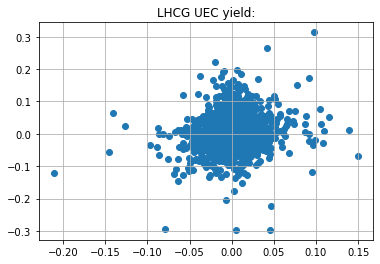

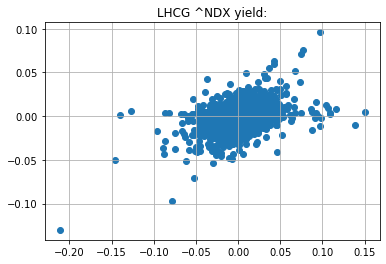

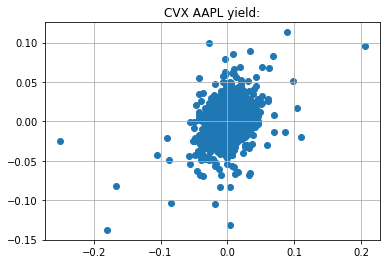

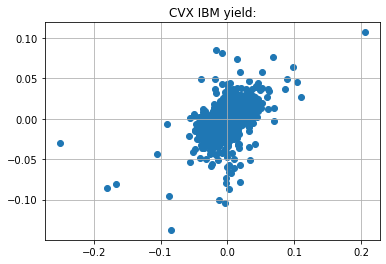

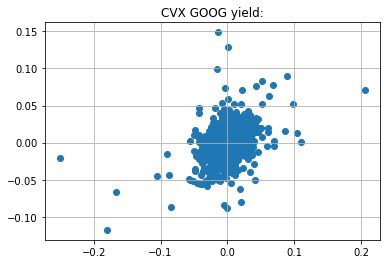

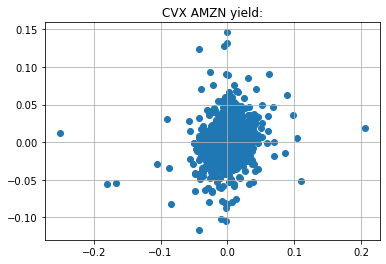

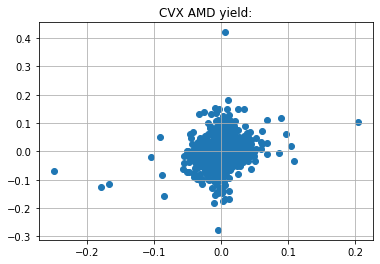

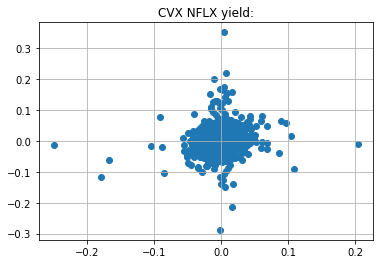

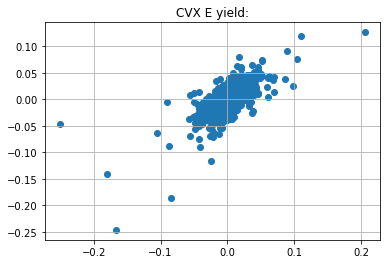

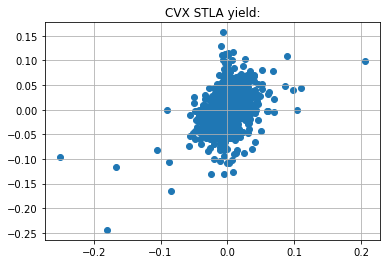

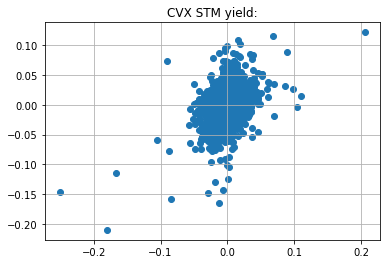

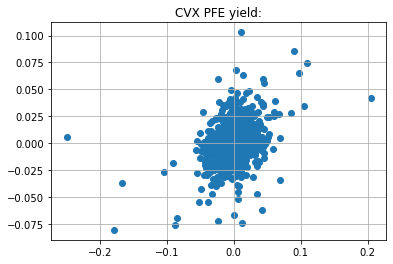

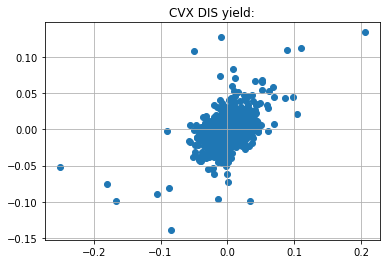

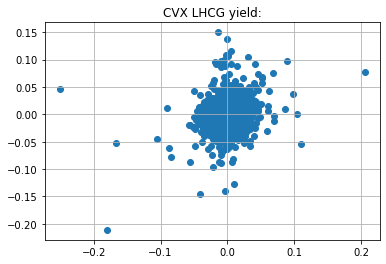

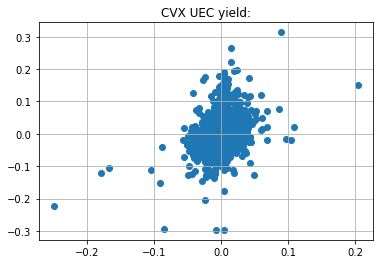

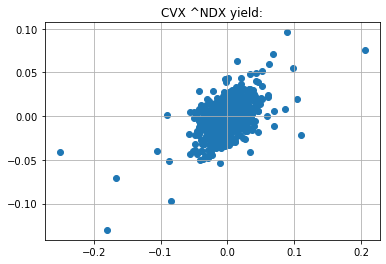

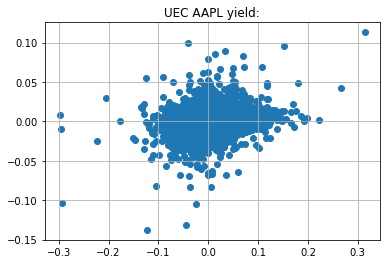

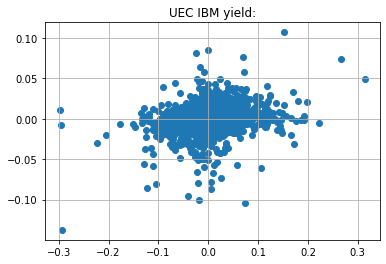

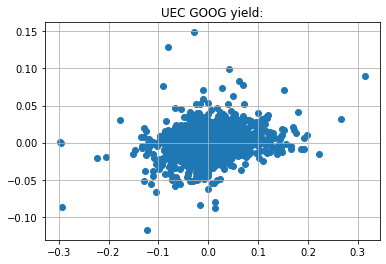

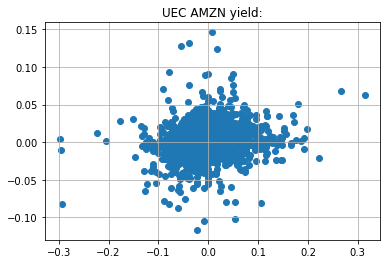

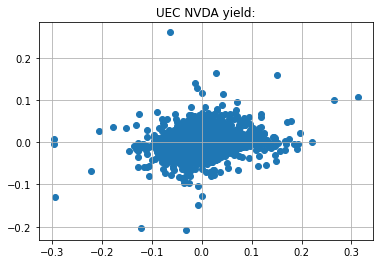

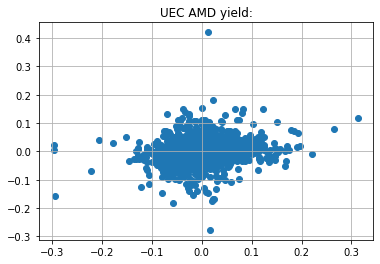

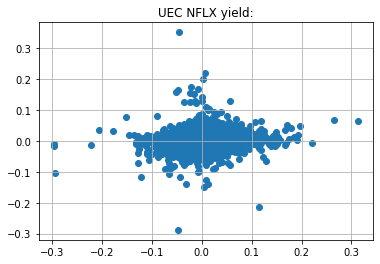

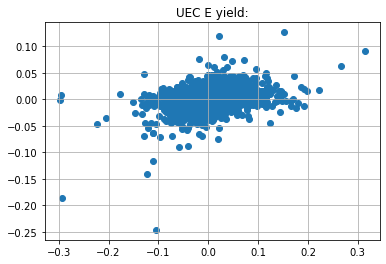

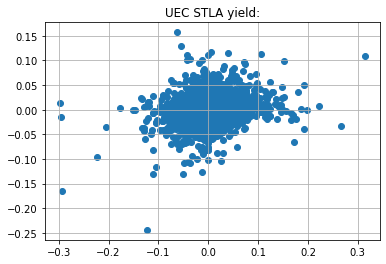

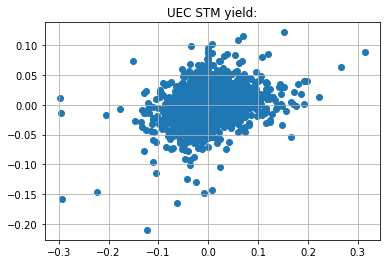

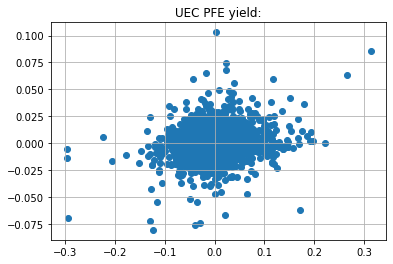

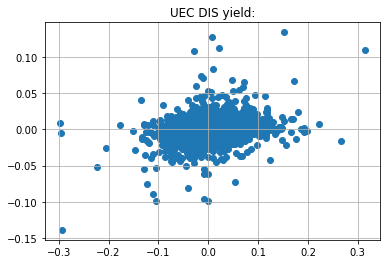

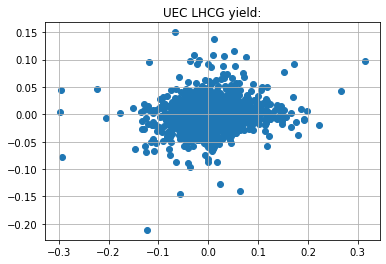

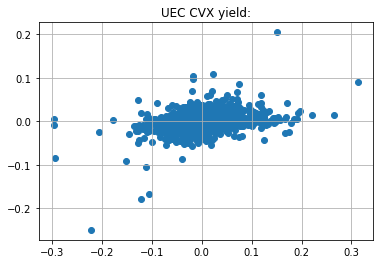

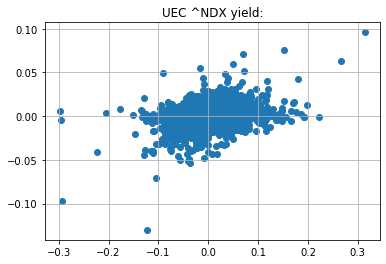

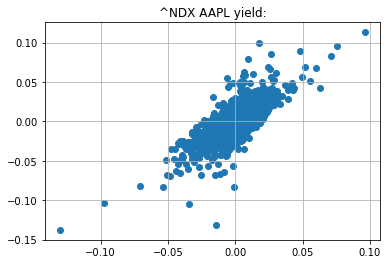

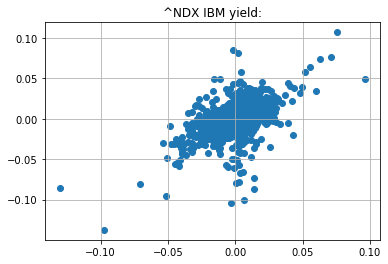

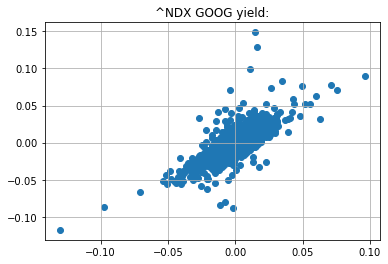

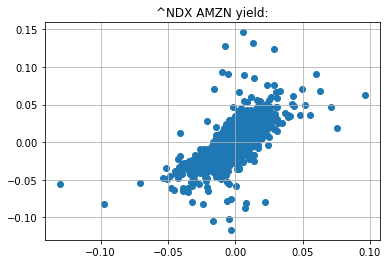

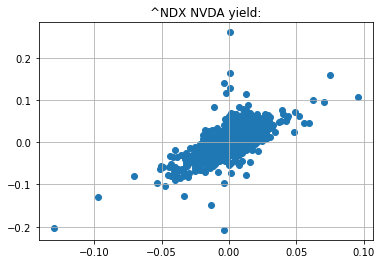

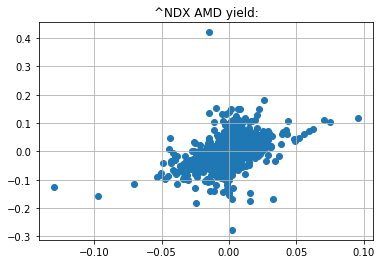

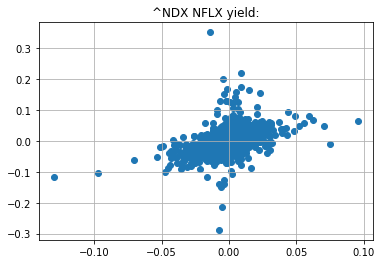

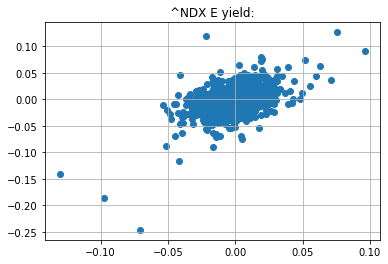

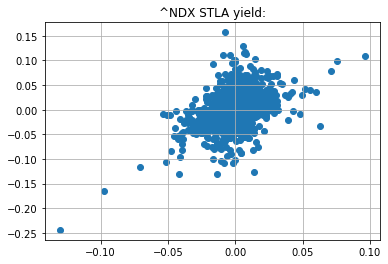

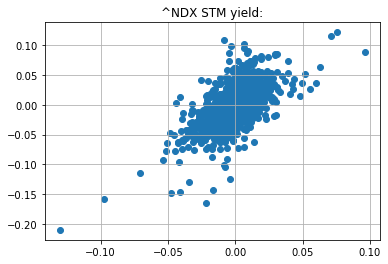

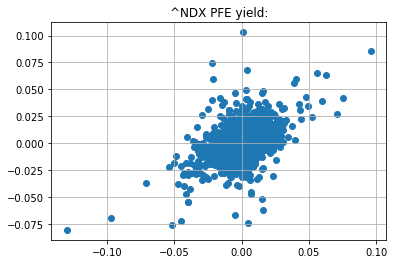

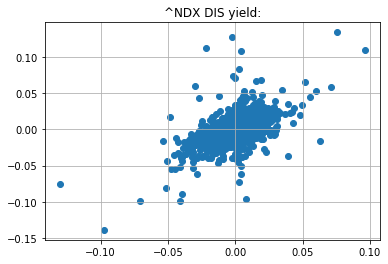

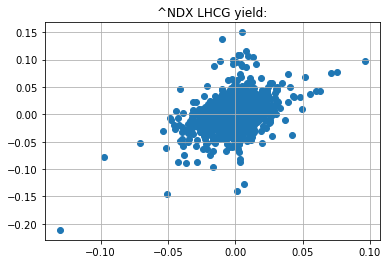

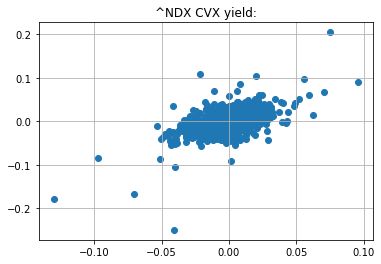

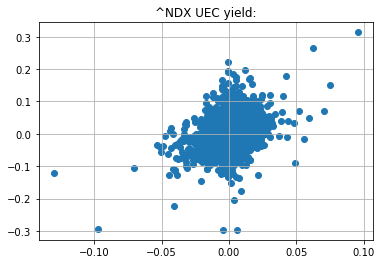

In [73]:
for col1 in merged_yield.columns.unique():
    for col2 in merged_yield.columns.unique():
        if col1 != col2:
            plt.scatter(merged_yield[col1], merged_yield[col2])
            plt.grid(True)
            plt.title(f"{col1} {col2} yield:")
            plt.show()

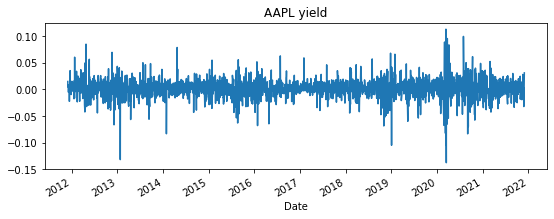

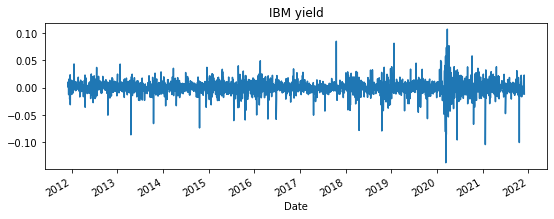

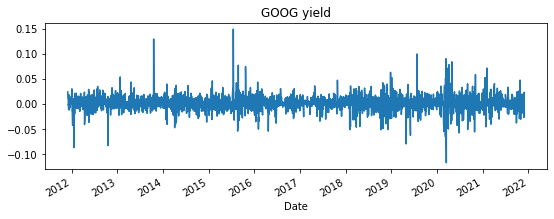

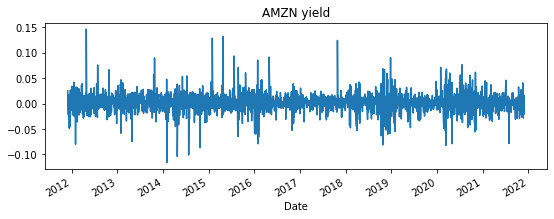

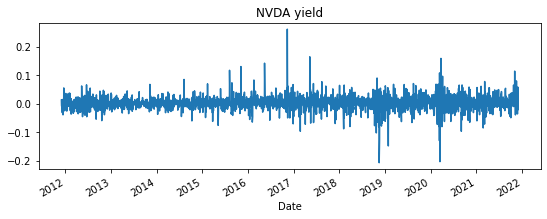

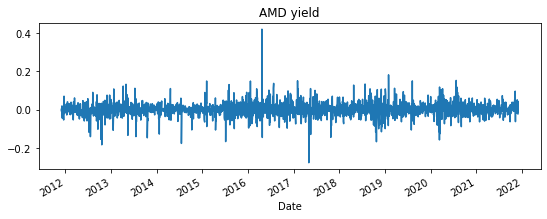

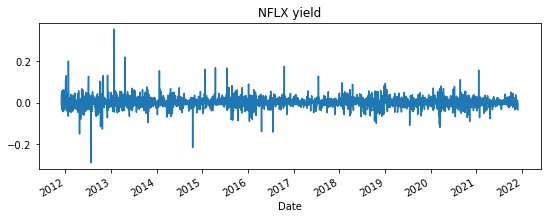

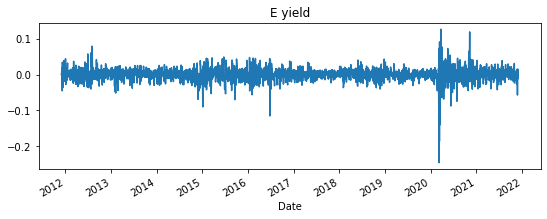

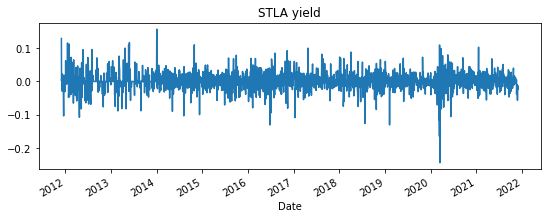

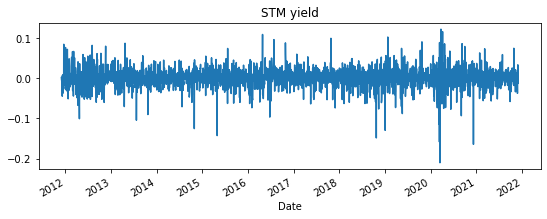

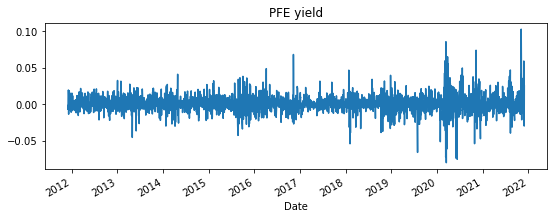

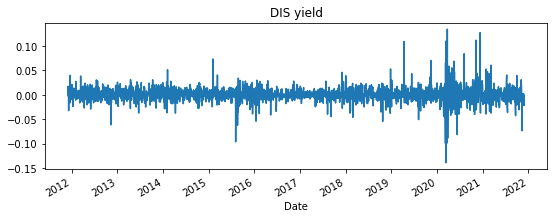

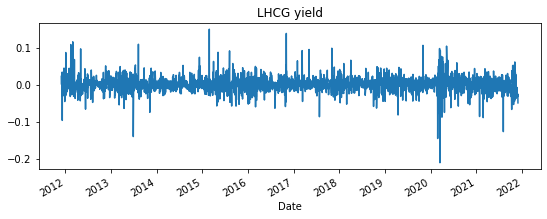

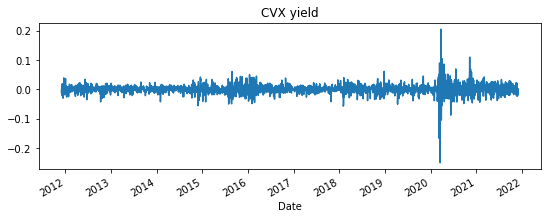

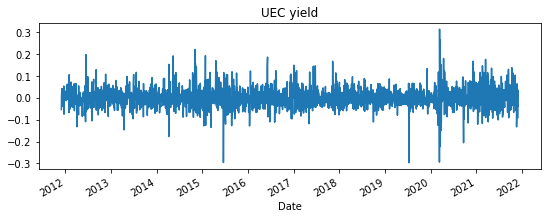

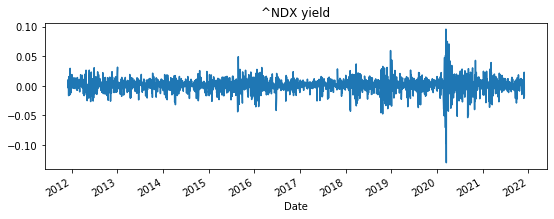

In [53]:
for col in merged_yield.columns:
    merged_yield[col].plot(figsize=(9, 3))
    plt.title(f"{col} yield")
    plt.show()


In [54]:
merged_df.groupby(pd.Grouper(freq='Q')).mean()

High_AAPL    Low_AAPL   Open_AAPL  Close_AAPL   Volume_AAPL  \
Date                                                                       
2011-12-31   14.109156   13.914334   14.008880   14.015812  3.051123e+08   
2012-03-31   18.112079   17.793992   17.950541   17.988566  5.453669e+08   
2012-06-30   21.005403   20.527903   20.809127   20.753220  5.485899e+08   
2012-09-30   23.032630   22.669093   22.849887   22.876553  4.188073e+08   
2012-12-31   20.927817   20.386187   20.729574   20.634424  6.000876e+08   
2013-03-31   16.863107   16.481637   16.698542   16.649083  5.274056e+08   
2013-06-30   15.582623   15.222014   15.410117   15.383677  4.285868e+08   
2013-09-30   16.742271   16.435720   16.588404   16.580195  3.629280e+08   
2013-12-31   19.033917   18.737980   18.880240   18.891892  3.143794e+08   
2014-03-31   19.174456   18.879549   19.024754   19.021593  3.220987e+08   
2014-06-30   21.413271   21.106015   21.247290   21.279382  2.698170e+08   
2014-09-30   24.739531   24.327422   24.531875   24.540859  2.186614e+08   
2014-12-31   27.465469   26.948008   27.198750   27.205313  2.033927e+08   
2015-03-31   30.514057   29.889016   30.249959   30.194262  2.347830e+08   
2015-06-30   32.242222   31.759048   32.018611   31.984524  1.796123e+08   
2015-09-30   29.688789   28.963242   29.357031   29.325859  2.419779e+08   
2015-12-31   28.839141   28.291836   28.590664   28.574844  1.740667e+08   
2016-03-31   25.169385   24.618688   24.890615   24.913770  1.854925e+08   
2016-06-30   25.066563   24.645742   24.849922   24.850313  1.595346e+08   
2016-09-30   26.629531   26.276172   26.425039   26.466523  1.427452e+08   
2016-12-31   28.540159   28.122936   28.318492   28.349762  1.280788e+08   
2017-03-31   33.041290   32.713387   32.829274   32.928145  1.096593e+08   
2017-06-30   37.205000   36.719960   36.990278   36.968849  1.086644e+08   
2017-09-30   39.065119   38.494127   38.809087   38.792262  1.119654e+08   
2017-12-31   42.018294   41.486230   41.740357   41.787064  1.038818e+08   
2018-03-31   43.524303   42.654017   43.068402   43.047828  1.509050e+08   
2018-06-30   45.678125   44.980117   45.301719   45.349141  1.134222e+08   
2018-09-30   52.473532   51.630238   52.006389   52.075000  1.125703e+08   
2018-12-31   49.216905   47.816468   48.632659   48.478016  1.682538e+08   
2019-03-31   42.764181   41.969795   42.335779   42.415943  1.279744e+08   
2019-06-30   49.139563   48.247698   48.615635   48.723175  1.117964e+08   
2019-09-30   52.753438   51.826523   52.271328   52.280195  1.060938e+08   
2019-12-31   64.668281   63.725820   64.142500   64.332187  1.033646e+08   
2020-03-31   74.693105   72.257581   73.282944   73.540927  1.973181e+08   
2020-06-30   78.341389   76.394960   77.244683   77.490317  1.478510e+08   
2020-09-30  110.836680  107.262734  109.268945  109.115351  1.714936e+08   
2020-12-31  121.803125  118.785468  120.305469  120.281250  1.146865e+08   
2021-03-31  130.072952  126.665082  128.612459  128.358033  1.102383e+08   
2021-06-30  130.613334  128.396825  129.437937  129.568889  8.267274e+07   
2021-09-30  148.502657  145.890312  147.152188  147.222969  8.091270e+07   
2021-12-31  150.963809  148.270475  149.287619  149.909762  7.752639e+07   

            Adj Close_AAPL    High_IBM     Low_IBM    Open_IBM   Close_IBM  \
Date                                                                         
2011-12-31       11.983770  181.001216  178.127498  179.721449  179.539806   
2012-03-31       15.380546  187.051286  185.004935  185.880775  186.175908   
2012-06-30       17.744375  191.691098  189.126073  190.381954  190.379678   
2012-09-30       19.609889  189.726547  187.332696  188.434550  188.523476   
2012-12-31       17.764079  187.954110  185.564670  186.799173  186.654229   
2013-03-31       14.408678  194.859146  192.850382  193.696781  194.012907   
2013-06-30       13.397509  196.165601  193.393583  194.831948  194.743966   
2013-09-30       14.538600  183.027755  18

In [55]:
for c in merged_df.columns:
    
    n = merged_df[c].isnull().sum()
    if n > 0:
        print(c)
        print(n)

In [56]:
pct_yield = pd.DataFrame()

for t in stocks_df.ticker.unique():
    
    col = f"Adj Close_{t}"
    print(col)

    pct_yield[t] = merged_df[col].pct_change(1).dropna()



Adj Close_AAPL
Adj Close_IBM
Adj Close_GOOG
Adj Close_AMZN
Adj Close_NVDA
Adj Close_AMD
Adj Close_NFLX
Adj Close_E
Adj Close_STLA
Adj Close_STM
Adj Close_PFE
Adj Close_DIS
Adj Close_LHCG
Adj Close_CVX
Adj Close_UEC
Adj Close_^NDX


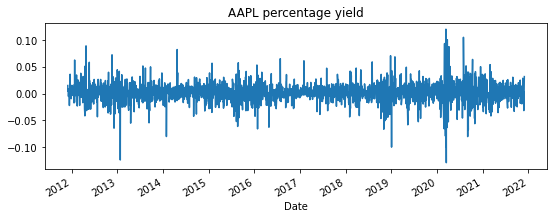

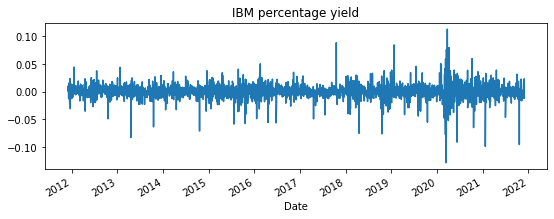

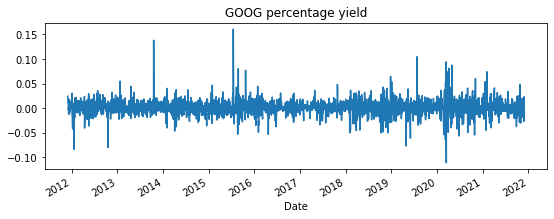

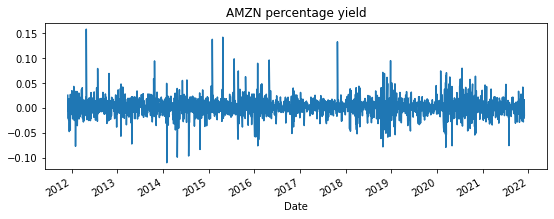

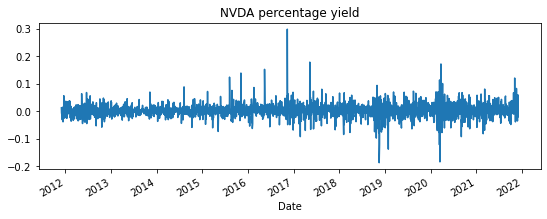

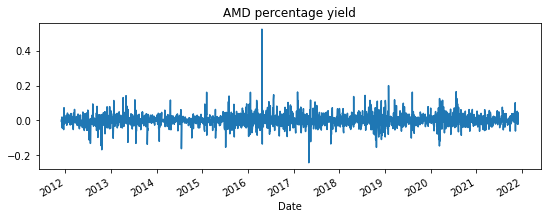

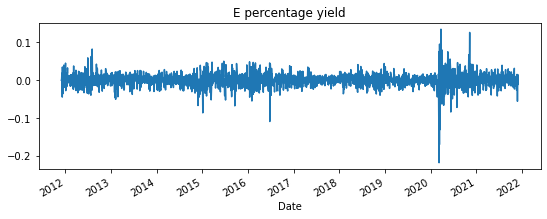

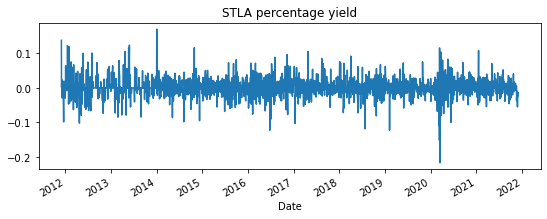

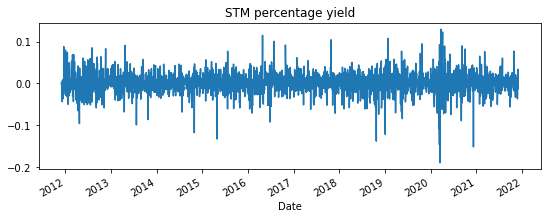

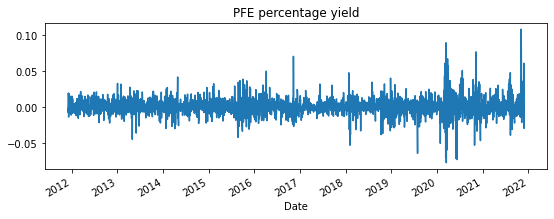

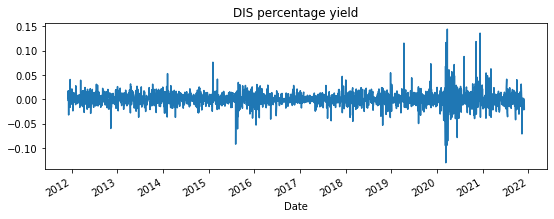

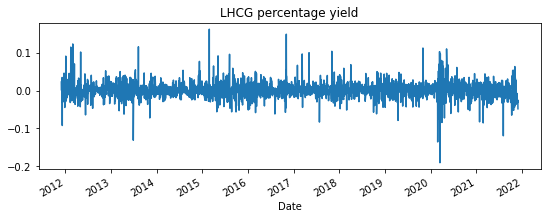

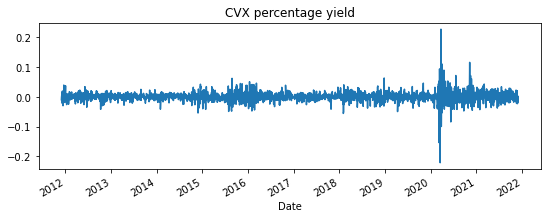

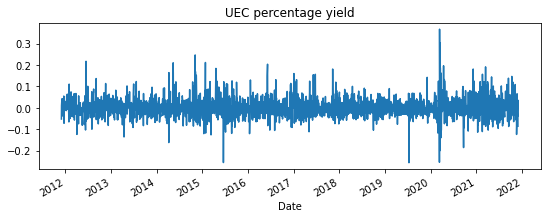

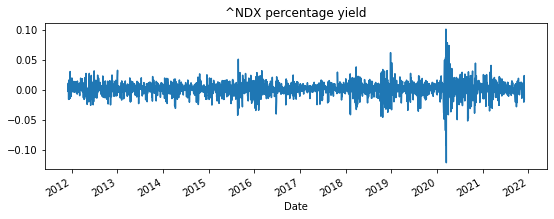

In [57]:
for col in pct_yield.columns:
    pct_yield[col].plot(figsize=(9, 3))
    plt.title(f"{col} percentage yield")
    plt.show()

In [103]:
df = pd.DataFrame({"yelds": [10, 15, 20]})



df["yelds_pct"] = df["yelds"].pct_change(1).dropna()


df["cumprod"] = np.cumprod(df["yelds_pct"] + 1)

df.head()

# ogni cumprod è calcolato come: cumprod(t-1)(1 + pct(t)) = cumprod(t)


yelds  yelds_pct  cumprod
0     10        NaN      NaN
1     15   0.500000      1.5
2     20   0.333333      2.0

In [59]:
# ogni cumprod è calcolato come: cumprod(t-1)(1 + pct(t)) = cumprod(t)

cumprod_perc =  np.cumprod(pct_yield+1)

cumprod_perc

AAPL       IBM      GOOG       AMZN       NVDA        AMD  \
Date                                                                         
2011-12-01   1.014992  1.007713  1.023991   1.025170   1.012156   1.001757   
2011-12-02   1.019623  1.008830  1.034986   1.019450   1.005758   0.992970   
2011-12-05   1.028284  1.015106  1.043811   1.020542   0.990403   1.012302   
2011-12-06   1.022894  1.026276  1.040675   0.998440   0.976327   0.994728   
2011-12-07   1.018027  1.032181  1.040041   1.015757   0.970569   1.005272   
...               ...       ...       ...        ...        ...        ...   
2021-11-23  13.792151  0.930239  9.830466  18.617921  88.431175  26.347978   
2021-11-24  13.837440  0.929761  9.827821  18.619844  91.016208  27.732865   
2021-11-26  13.399091  0.922434  9.565810  18.225388  87.754287  27.207381   
2021-11-29  13.692177  0.943860  9.787395  18.521869  92.971685  28.455185   
2021-11-30  14.124545  0.932708  9.542098  18.238442  91.021779  27.833039   

                 NFLX         E      STLA        STM       PFE       DIS  \
Date                                                                       
2011-12-01   1.040911  1.000000  1.137778   1.001580  0.998007  1.003905   
2011-12-02   1.028514  0.999765  1.140000   0.998420  0.991031  1.021199   
2011-12-05   1.086627  1.018375  1.166667   0.988942  0.988540  1.030404   
2011-12-06   1.055943  1.025206  1.166667   0.987362  1.007972  1.027336   
2011-12-07   1.115140  1.026384  1.142222   0.976303  1.019930  1.034867   
...               ...       ...       ...        ...       ...       ...   
2021-11-23  70.950261  1.168732  8.869586  10.689983  3.861453  4.784280   
2021-11-24  71.409115  1.157506  8.657527  10.589174  3.847090  4.794100   
2021-11-26  72.206423  1.093062  8.182700  10.198811  4.082194  4.691781   
2021-11-29  72.011166  1.109277  8.081281  10.544133  3.961240  4.682278   
2021-11-30  69.631187  1.097219  7.896881  10.411152  4.061783  4.590095   

                LHCG       CVX       UEC      ^NDX  
Date                                                
2011-12-01  1.002158  0.990371  0.947541  1.006100  
2011-12-02  1.026619  0.989010  0.957377  1.002980  
2011-12-05  1.011511  1.000000  0.996721  1.013833  
2011-12-06  0.981295  1.014977  1.003279  1.011454  
2011-12-07  1.015108  1.016533  1.029508  1.011040  
...              ...       ...       ...       ...  
2021-11-23  9.370504  1.706631  1.432787  7.104706  
2021-11-24  9.196403  1.719691  1.416394  7.131322  
2021-11-26  8.894964  1.680363  1.357377  6.982215  
2021-11-29  8.670504  1.685353  1.406557  7.145016  
2021-11-30  8.253238  1.656297  1.285246  7.030289  

[2516 rows x 16 columns]

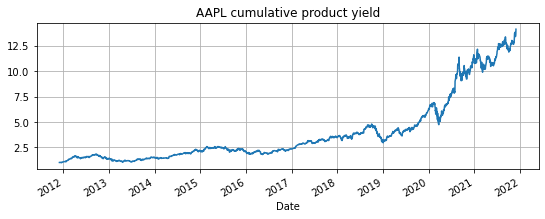

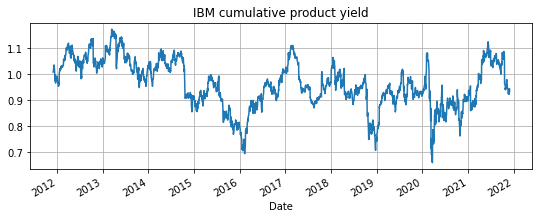

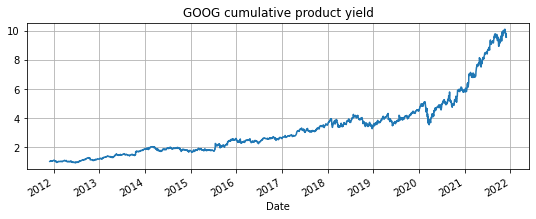

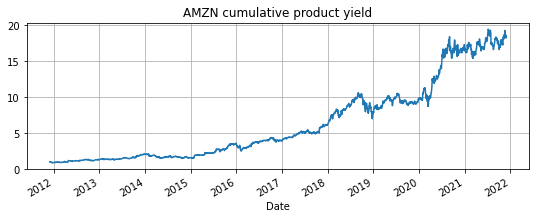

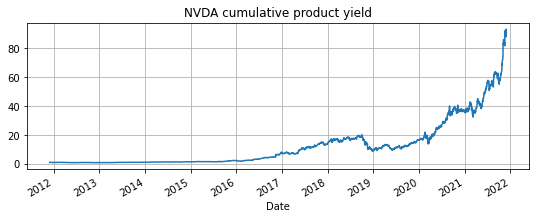

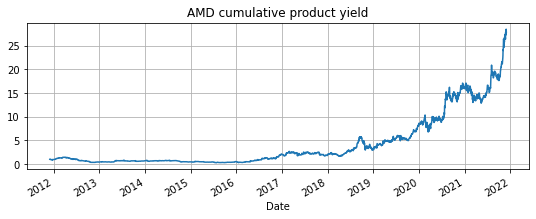

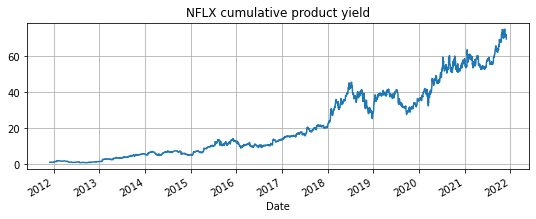

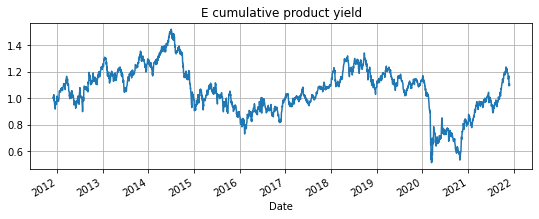

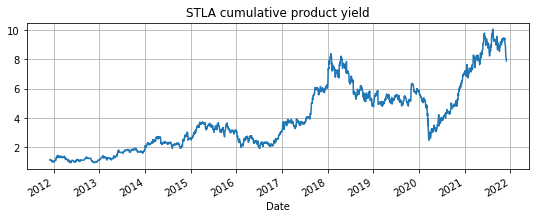

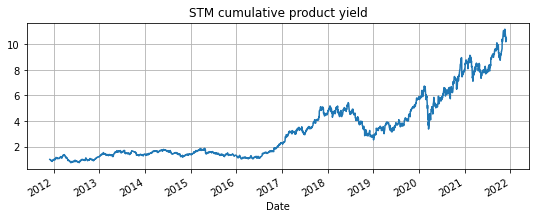

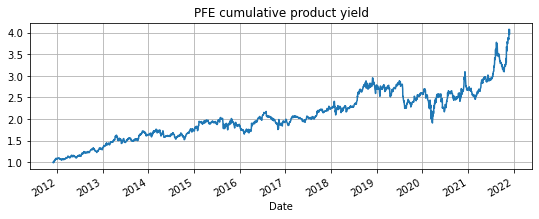

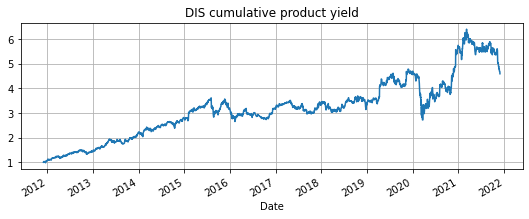

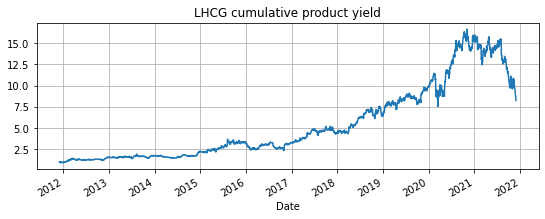

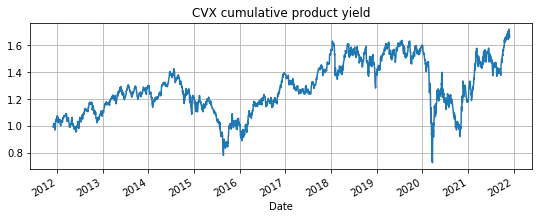

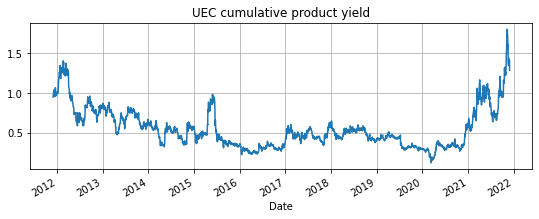

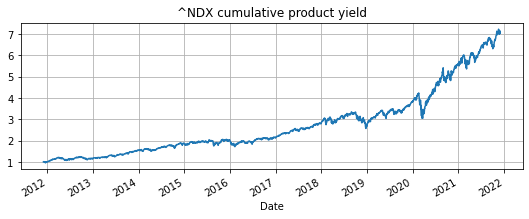

In [60]:
#cumprod_perc.plot(figsize=(18, 9), color = sns.color_palette("Set2"))
#plt.legend(loc=2, prop={'size': 20})

for col in cumprod_perc.columns:
    cumprod_perc[col].plot(figsize=(9, 3), grid=True)
    plt.title(f"{col} cumulative product yield")
    plt.show()

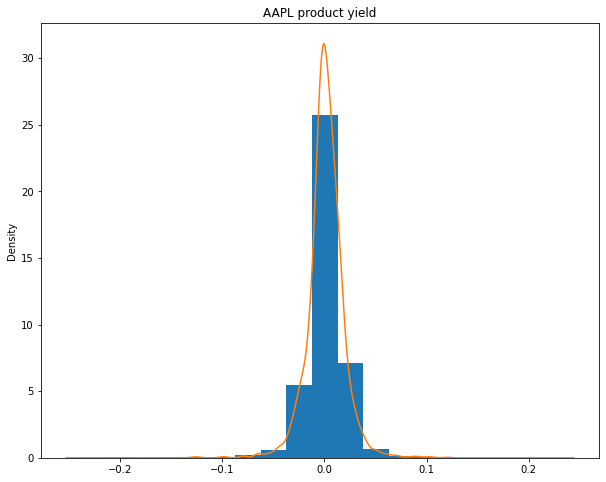

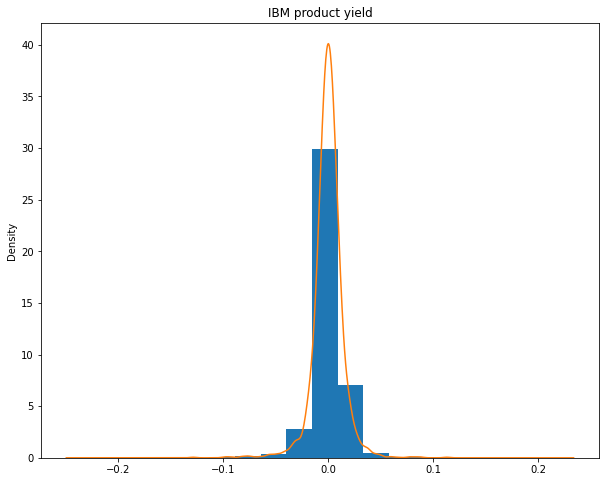

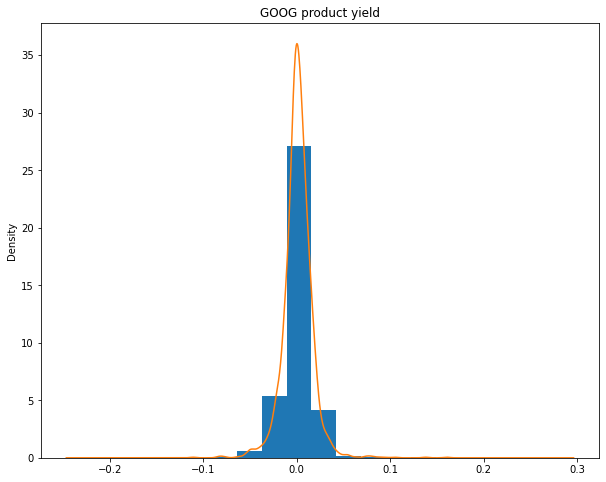

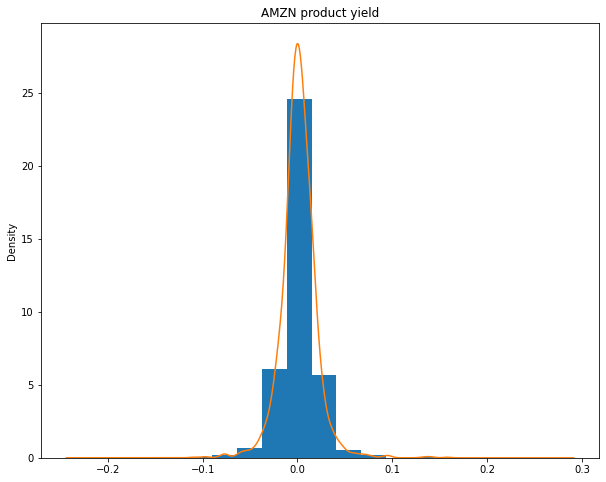

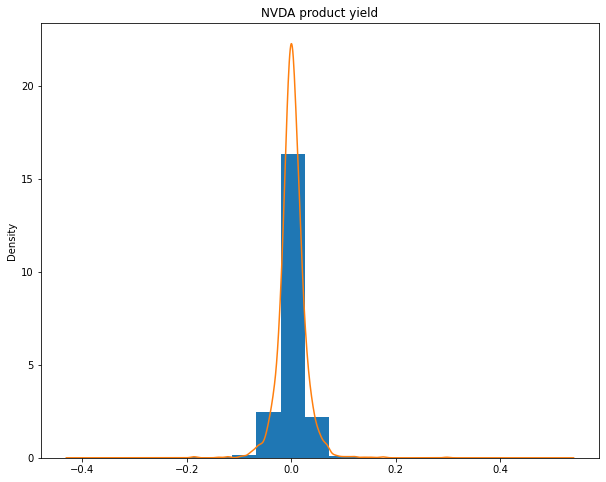

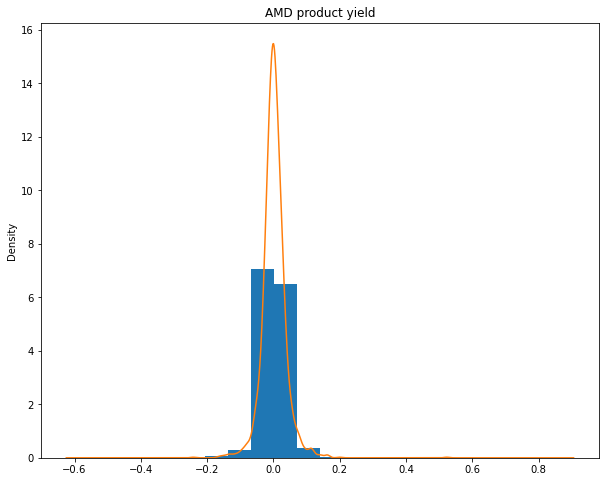

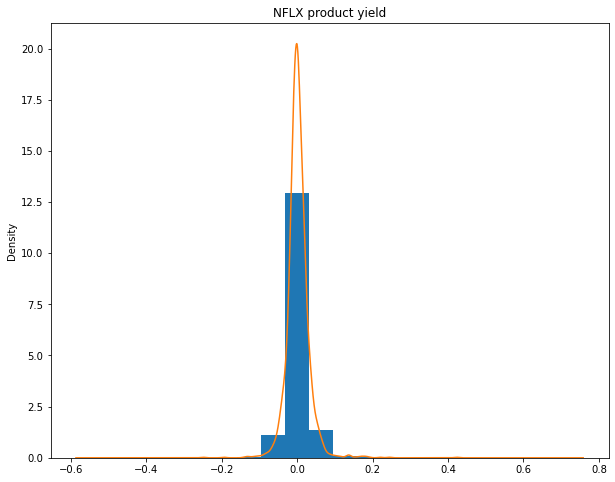

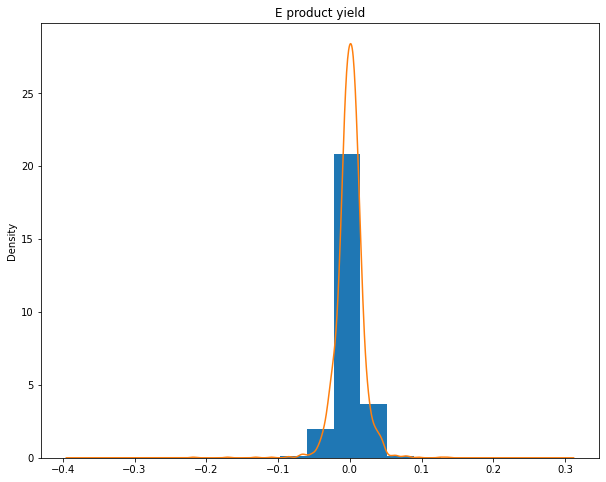

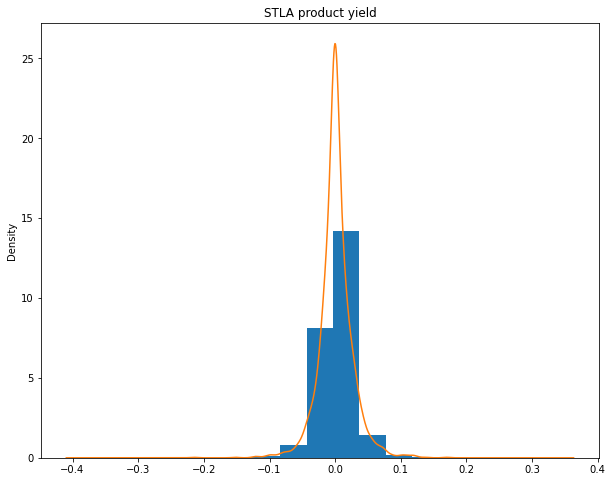

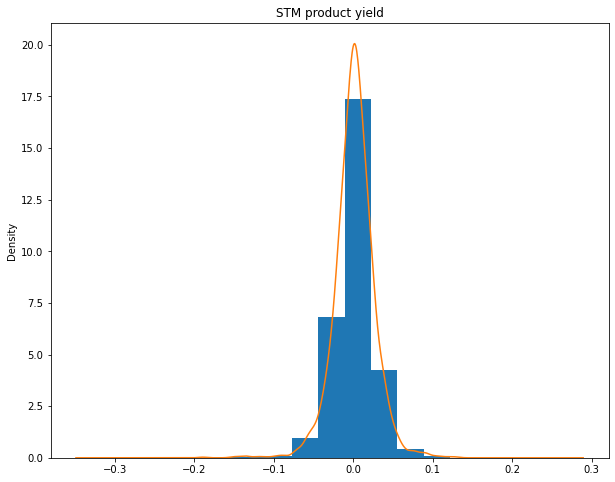

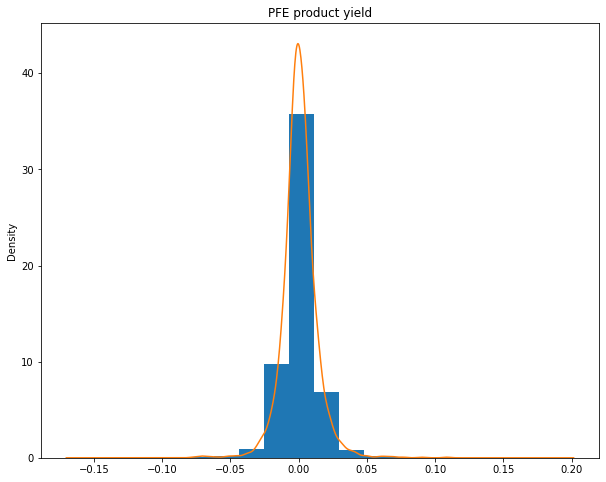

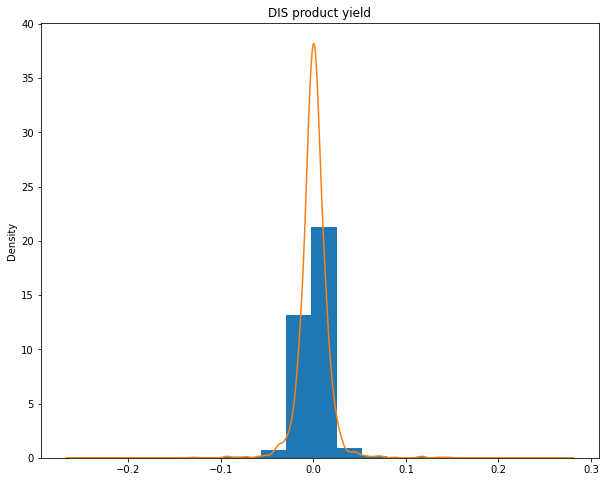

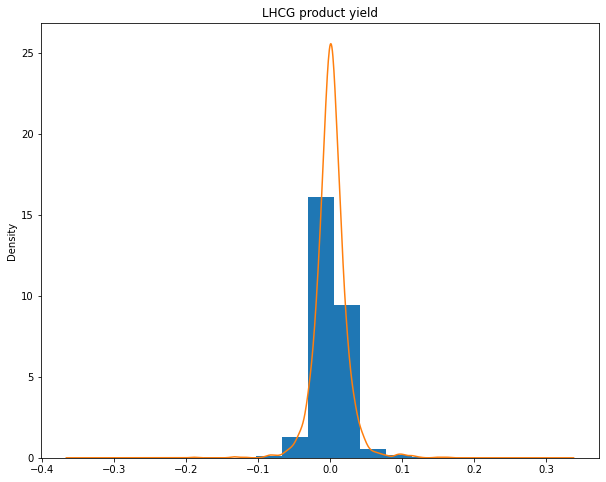

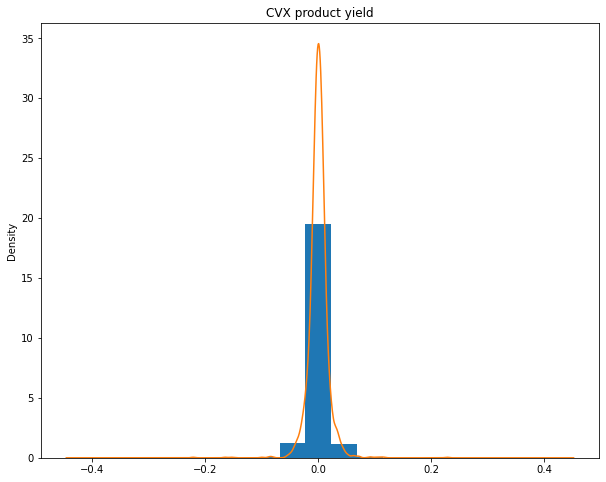

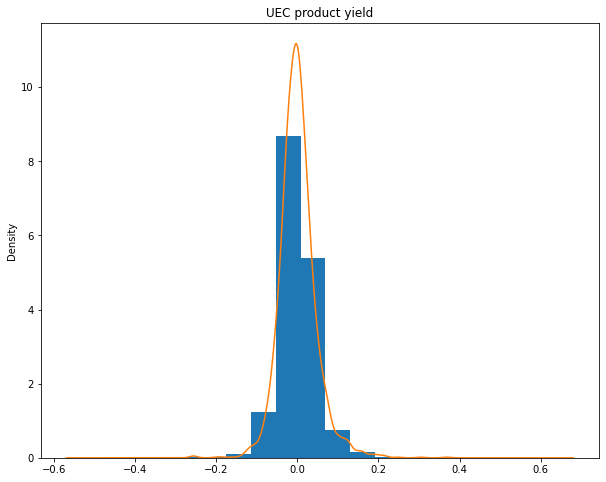

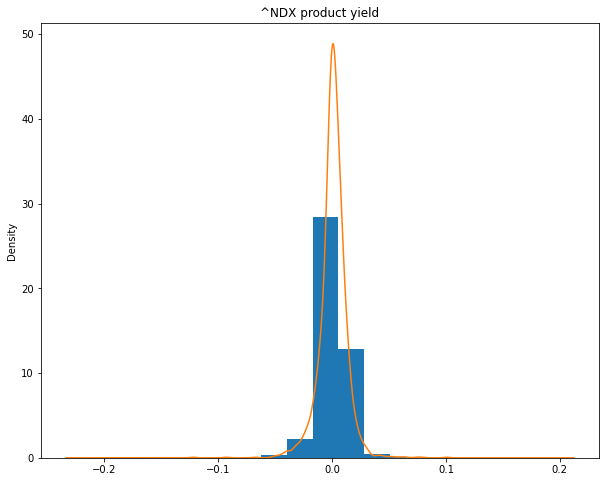

In [61]:
for col in merged_yield.columns:
    plt.figure(figsize=(10, 8))
    plt.title(f"{col} product yield")
    plt.hist(merged_yield[col], density = True)
    pct_yield[col].plot.density()
    plt.show()

In [62]:
merged_yield.mean().sort_values(ascending=False)

NVDA    0.001793
NFLX    0.001686
AMD     0.001322
AMZN    0.001154
AAPL    0.001052
STM     0.000931
GOOG    0.000897
LHCG    0.000839
STLA    0.000821
^NDX    0.000775
DIS     0.000606
PFE     0.000557
CVX     0.000201
UEC     0.000100
E       0.000037
IBM    -0.000028
dtype: float64

In [63]:
merged_yield.var().sort_values(ascending=False)

UEC     0.002066
AMD     0.001280
NFLX    0.000871
STLA    0.000682
STM     0.000663
NVDA    0.000644
LHCG    0.000481
AMZN    0.000360
E       0.000341
AAPL    0.000318
CVX     0.000306
GOOG    0.000250
DIS     0.000235
IBM     0.000210
PFE     0.000164
^NDX    0.000148
dtype: float64

In [64]:
merged_yield.std().sort_values(ascending=False)

UEC     0.045449
AMD     0.035784
NFLX    0.029512
STLA    0.026106
STM     0.025752
NVDA    0.025370
LHCG    0.021933
AMZN    0.018983
E       0.018457
AAPL    0.017835
CVX     0.017480
GOOG    0.015818
DIS     0.015335
IBM     0.014483
PFE     0.012792
^NDX    0.012162
dtype: float64

In [65]:
# asimmetria

merged_yield.skew().sort_values(ascending=False)

NFLX    0.784813
AMD     0.366044
AMZN    0.268812
GOOG    0.266809
UEC     0.264640
DIS     0.231791
PFE     0.162642
NVDA    0.113288
LHCG   -0.127049
STLA   -0.343653
AAPL   -0.360463
STM    -0.681752
^NDX   -0.700412
IBM    -0.906504
CVX    -1.122765
E      -1.438786
dtype: float64

In [66]:
merged_yield.kurtosis().sort_values(ascending=False)

CVX     34.782451
E       21.217685
NFLX    18.207047
DIS     14.362254
AMD     11.914548
IBM     11.852062
^NDX    11.769461
NVDA    11.458806
GOOG     9.955794
LHCG     9.367154
PFE      7.431006
AMZN     7.246314
STLA     7.229008
AAPL     6.891061
STM      5.833703
UEC      5.099488
dtype: float64

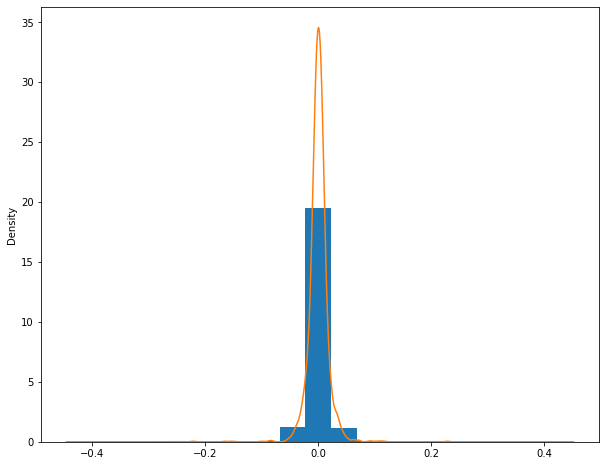

In [67]:
plt.figure(figsize=(10, 8))

plt.hist(merged_yield['CVX'], density = True)
pct_yield['CVX'].plot.density()
plt.show()

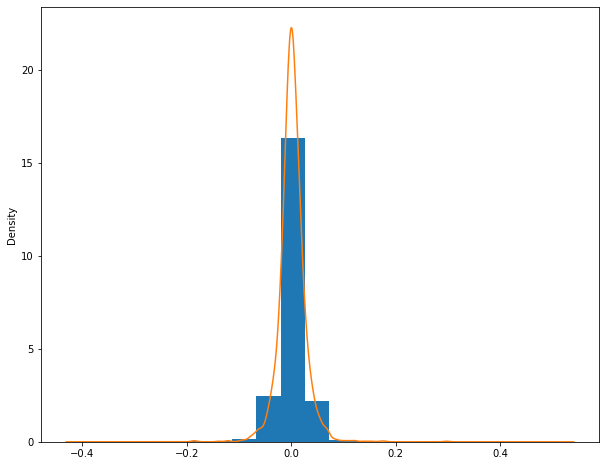

In [68]:
plt.figure(figsize=(10, 8))

plt.hist(merged_yield['NVDA'], density = True)
pct_yield['NVDA'].plot.density()
plt.show()

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

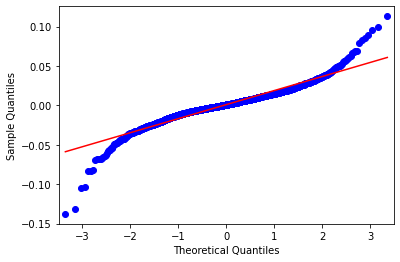

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

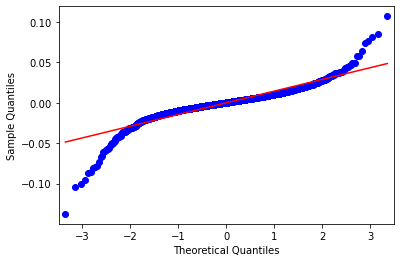

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

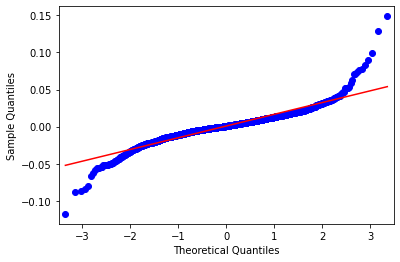

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

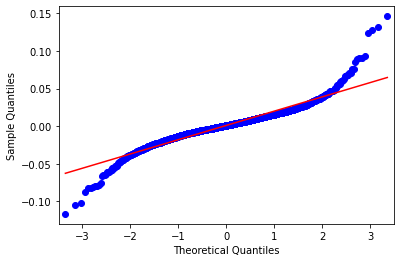

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

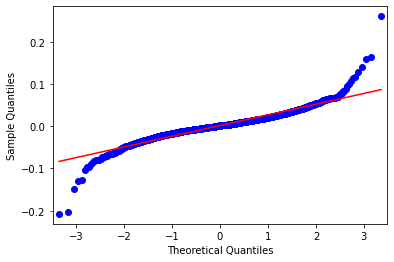

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

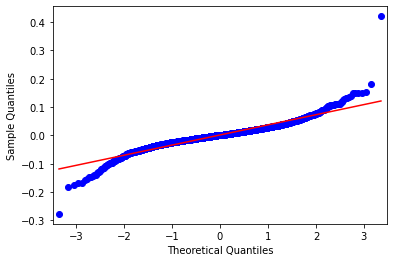

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

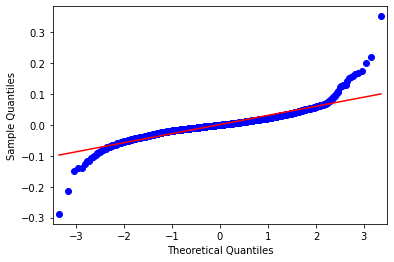

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

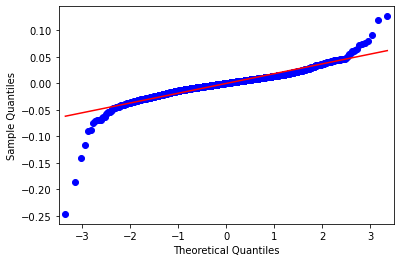

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

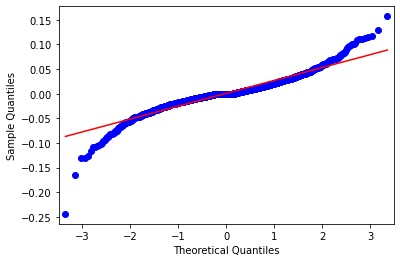

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

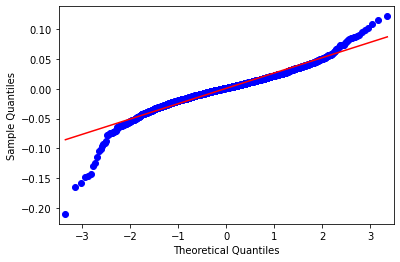

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

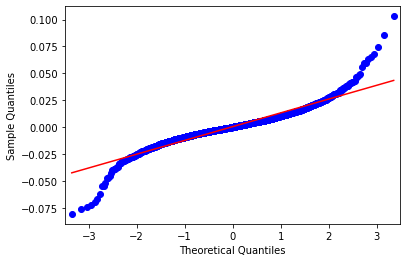

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

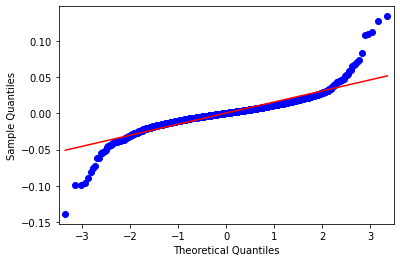

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

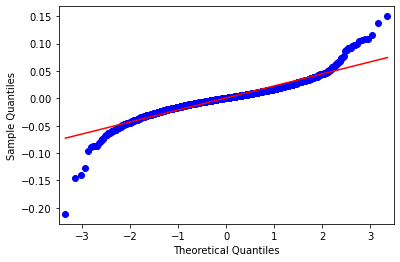

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

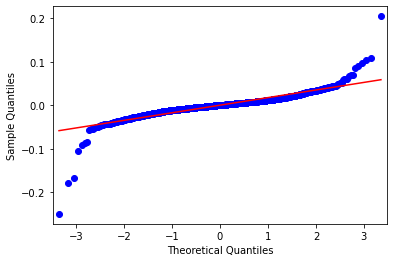

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

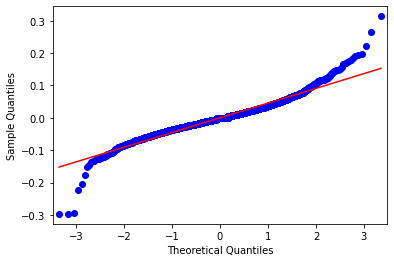

C:\Users\samue\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x576 with 0 Axes>

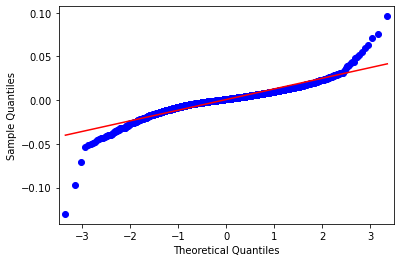

In [69]:
for col in merged_yield.columns:
    plt.figure(figsize=(10, 8))

    sm.qqplot(merged_yield[col], line='s')


    plt.show()

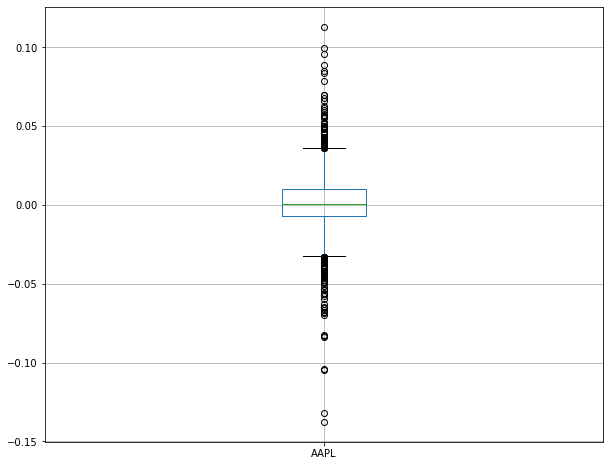

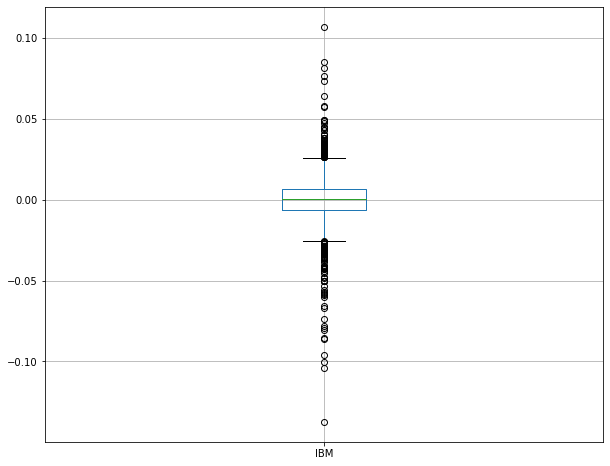

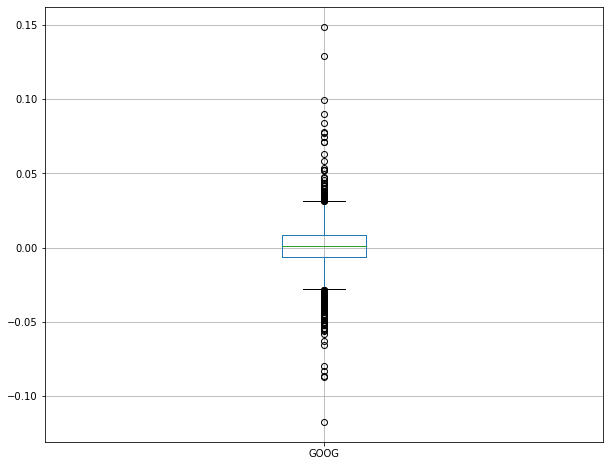

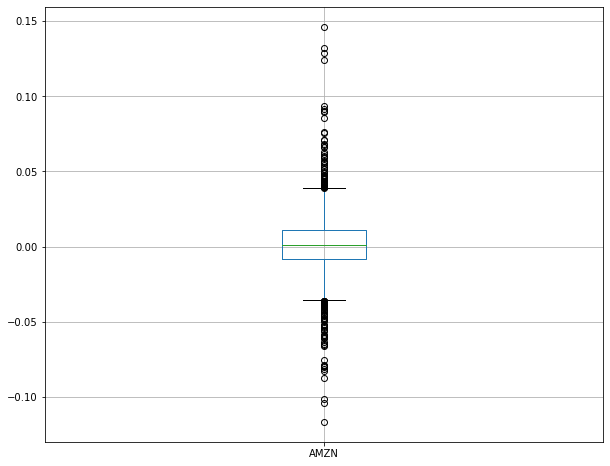

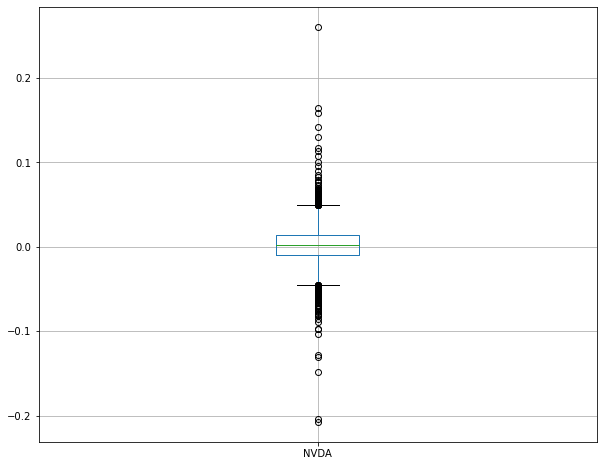

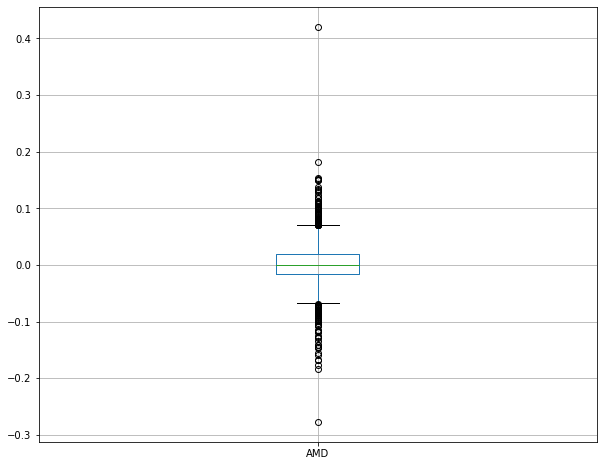

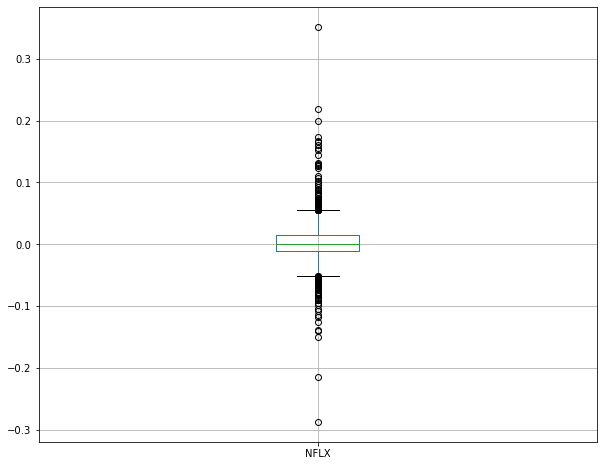

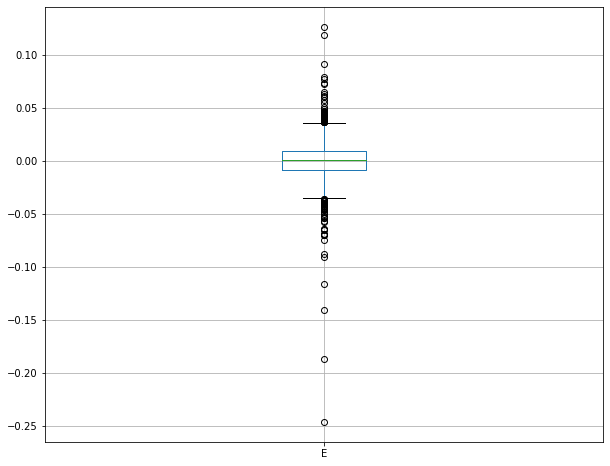

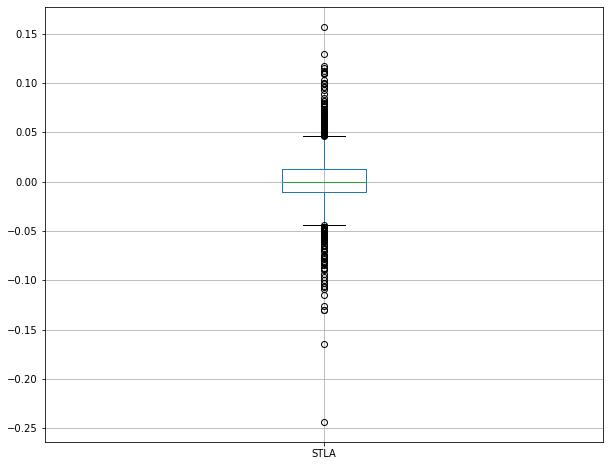

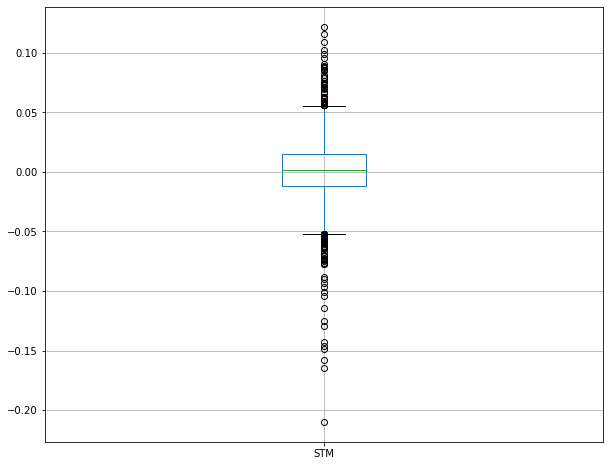

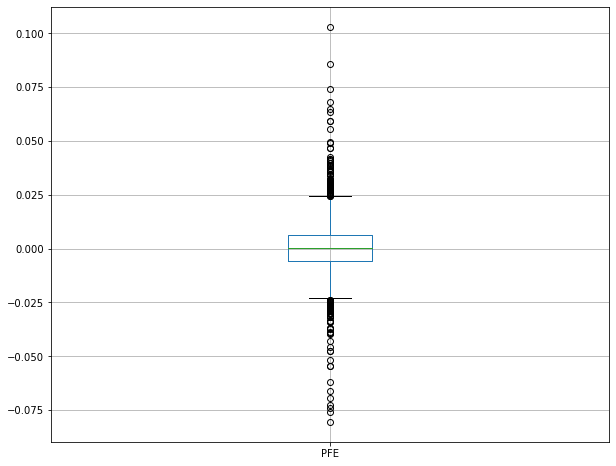

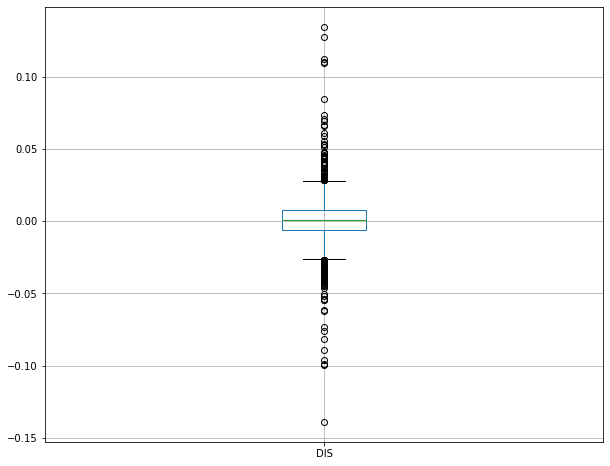

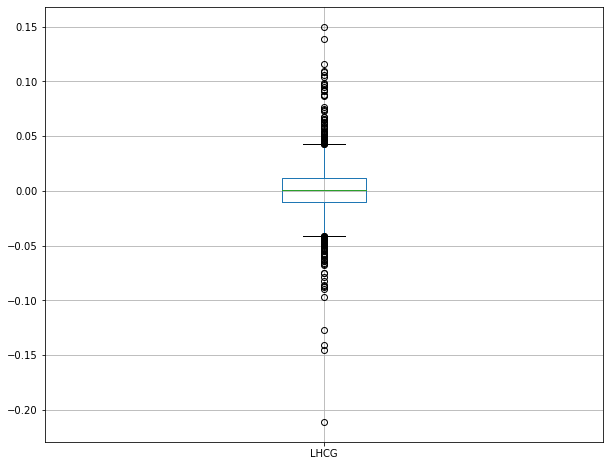

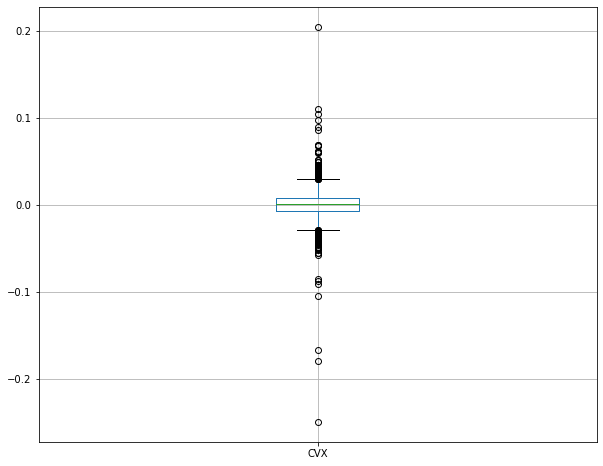

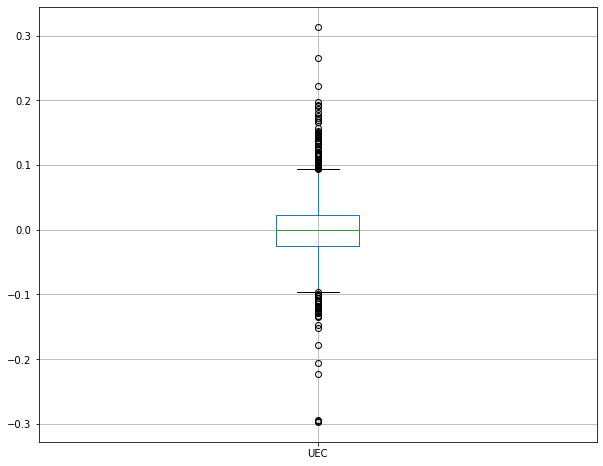

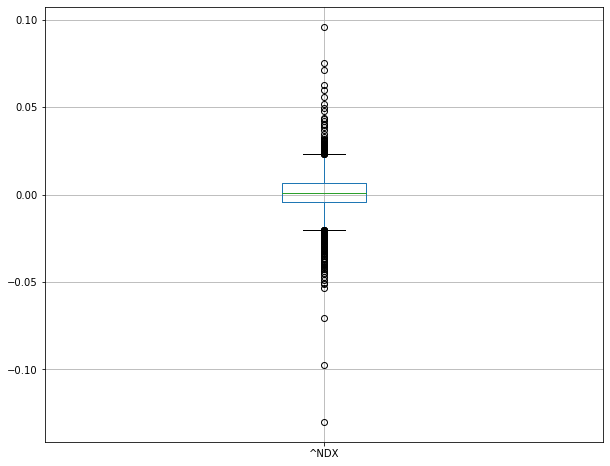

In [70]:
for col in merged_yield.columns:
    plt.figure(figsize=(10, 8))
    merged_yield[col].to_frame().boxplot()


    plt.show()

